In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
from matplotlib.image import imread
from matplotlib.pyplot import imshow

# Courses libraries 
from ops import *
from utils import *
%load_ext autoreload
%autoreload 2c

/home/vitalii/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
# Configurate sesion. 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [3]:
DATA_PATH = 'celebA/' 
Z_DIM=100 
GENERATOR_DENSE_SIZE=64*8 

IMAGE_SIZE=64 
BATCH_SIZE=64 
N_CHANNELS = 3

MERGE_X = 8 
MERGE_Y = 8

In [4]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

In [5]:
GENERATOR_DENSE_SIZE

512

In [6]:
def generator(z, is_training, batch_norms=None):
    """
        Create generator part of network.
        Used: https://arxiv.org/pdf/1511.06434.pdf 
    """
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_linear')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    h_in = tf.nn.relu(batch_norms[0](h_in, train=is_training))
    
    h_0 = deconv2d(h_in, output_shape=[BATCH_SIZE, 8, 8, 256], name='g_h1_deconv')
    h_0 = tf.nn.relu(batch_norms[1](h_0, train=is_training))
    
    h_1 = deconv2d(h_0, output_shape=[BATCH_SIZE, 16, 16, 128], name='g_h2_deconv')
    h_1 = tf.nn.relu(batch_norms[2](h_1, train=is_training))
    
    h_2 = deconv2d(h_1, output_shape=[BATCH_SIZE, 32, 32, 64], name='g_h3_deconv')
    h_2 = tf.nn.relu(batch_norms[3](h_2, train=is_training))
    
    h_out = deconv2d(h_2, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')
    
    return tf.nn.tanh(h_out)

In [7]:
def discriminator(image, is_training, batch_norms=None):
    """
        Create discriminator part of network.
        Used: https://arxiv.org/pdf/1511.06434.pdf 
    """
    h0 = lrelu(conv2d(image, output_dim=64, name='d_h0_conv'))
    
    h1 = conv2d(h0, output_dim=128, name='d_h1_conv')
    h1 = lrelu(batch_norms[0](h1,train=is_training))
    
    h2 = conv2d(h1, output_dim=256, name='d_h2_conv')
    h2 = lrelu(batch_norms[1](h2,train=is_training))
    
    h3 = conv2d(h2, output_dim=512, name='d_h3_conv')
    h3 = lrelu(batch_norms[2](h3,train=is_training))
    
    h4 = tf.layers.Flatten(data_format='channels_last', name='d_h4_flatten')(h3)

    linear_out = linear(h4, 1, scope='d_h5_linear')
    
    return tf.nn.sigmoid(linear_out), linear_out

In [8]:
# Init network and training params.
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    g_batch_norms=[batch_norm(name='g_bn0'), batch_norm(name='g_bn1'),\
                   batch_norm(name='g_bn2'), batch_norm(name='g_bn3')]
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training, batch_norms=g_batch_norms)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    d_batch_norms=[batch_norm(name='d_bn0'), batch_norm(name='d_bn1'),\
                   batch_norm(name='d_bn2')]
    D_real, D_real_logits = discriminator(images, is_training, batch_norms=d_batch_norms)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training, batch_norms=d_batch_norms)

In [9]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits,labels=tf.ones_like(D_real)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,labels=tf.zeros_like(D_fake)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,labels=tf.ones_like(D_fake)))

In [10]:
tvars = tf.trainable_variables()
d_vars = [v for v in tvars if 'd_' in v.name]
g_vars = [v for v in tvars if 'g_' in v.name]
LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

d_optim = tf.train.AdamOptimizer(LEARNING_RATE,\
                                 beta1=BETA).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE,\
                                 beta1=BETA).minimize(g_loss, var_list=g_vars) 

In [11]:
# Load data.
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"
print(len(data))

166889


In [12]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

In [13]:
# Training ...
def train(sess,\
          load_dir=None,\
          save_frequency=100,\
          sample_frequency=500,\
          sample_dir='sample_faces',\
          save_dir='checkpoint',\
          max_to_keep=1,\
          model_name='dcgan.model',
          n_epochs=25,\
          n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs): 
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE 
        
        for idx in range(0, batch_idxs):
            
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            sess.run(d_optim,\
                     feed_dict={images: batch_images,\
                                z: batch_z,\
                                is_training: True})

            for _ in range(n_generator_update):
                sess.run(g_optim,\
                         feed_dict={z: batch_z,\
                                    is_training: True})
            
            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False})
                save_images(samples,\
                            [MERGE_X, MERGE_Y],\
                            os.path.join(sample_dir,\
                                         'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Save samples")

In [16]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint', n_epochs=3)

Epoch: [ 0] [   0/2607] time: 2.3521, d_loss: 1.39543521, g_loss: 0.46167678
Epoch: [ 0] [   1/2607] time: 2.6101, d_loss: 1.41541386, g_loss: 0.42744818
Epoch: [ 0] [   2/2607] time: 2.8631, d_loss: 1.31602454, g_loss: 0.53418499
Epoch: [ 0] [   3/2607] time: 3.1173, d_loss: 1.25229955, g_loss: 0.79347277
Epoch: [ 0] [   4/2607] time: 3.3713, d_loss: 1.24994886, g_loss: 0.98964608
Epoch: [ 0] [   5/2607] time: 3.6203, d_loss: 1.33473921, g_loss: 1.34393227
Epoch: [ 0] [   6/2607] time: 3.8745, d_loss: 1.29058456, g_loss: 1.49391973
Epoch: [ 0] [   7/2607] time: 4.1230, d_loss: 1.70054293, g_loss: 2.01894093
Epoch: [ 0] [   8/2607] time: 4.3749, d_loss: 1.47263741, g_loss: 1.83122540
Epoch: [ 0] [   9/2607] time: 4.6306, d_loss: 1.72858608, g_loss: 2.64907432
Epoch: [ 0] [  10/2607] time: 4.8918, d_loss: 2.34207964, g_loss: 1.92795050
Epoch: [ 0] [  11/2607] time: 5.1430, d_loss: 3.04914665, g_loss: 3.00463343
Epoch: [ 0] [  12/2607] time: 5.3952, d_loss: 2.44563818, g_loss: 1.49177814

Epoch: [ 0] [ 105/2607] time: 30.5784, d_loss: 2.97784042, g_loss: 1.06313300
Epoch: [ 0] [ 106/2607] time: 30.8631, d_loss: 2.04401875, g_loss: 0.74934548
Epoch: [ 0] [ 107/2607] time: 31.1275, d_loss: 1.73265505, g_loss: 1.00006199
Epoch: [ 0] [ 108/2607] time: 31.4302, d_loss: 2.03477192, g_loss: 0.56300378
Epoch: [ 0] [ 109/2607] time: 31.6796, d_loss: 1.33076453, g_loss: 0.60473049
Epoch: [ 0] [ 110/2607] time: 31.9339, d_loss: 1.80224204, g_loss: 0.74736071
Epoch: [ 0] [ 111/2607] time: 32.2114, d_loss: 2.33056307, g_loss: 0.61254048
Epoch: [ 0] [ 112/2607] time: 32.4949, d_loss: 2.42922807, g_loss: 0.47454709
Epoch: [ 0] [ 113/2607] time: 32.7574, d_loss: 2.69639111, g_loss: 0.38096932
Epoch: [ 0] [ 114/2607] time: 33.0099, d_loss: 2.48951626, g_loss: 0.54341221
Epoch: [ 0] [ 115/2607] time: 33.2915, d_loss: 2.11636090, g_loss: 0.75685209
Epoch: [ 0] [ 116/2607] time: 33.5811, d_loss: 2.17092419, g_loss: 0.79530925
Epoch: [ 0] [ 117/2607] time: 33.8816, d_loss: 2.15444016, g_los

Epoch: [ 0] [ 210/2607] time: 59.0044, d_loss: 1.96381974, g_loss: 0.76370156
Epoch: [ 0] [ 211/2607] time: 59.2580, d_loss: 1.75085676, g_loss: 0.62049454
Epoch: [ 0] [ 212/2607] time: 59.5135, d_loss: 1.39064372, g_loss: 0.78470182
Epoch: [ 0] [ 213/2607] time: 59.7621, d_loss: 1.19020724, g_loss: 1.01259959
Epoch: [ 0] [ 214/2607] time: 60.0208, d_loss: 1.30308890, g_loss: 0.73277545
Epoch: [ 0] [ 215/2607] time: 60.2739, d_loss: 1.34642708, g_loss: 0.74662089
Epoch: [ 0] [ 216/2607] time: 60.5256, d_loss: 1.73055303, g_loss: 0.57561868
Epoch: [ 0] [ 217/2607] time: 60.7765, d_loss: 1.56761408, g_loss: 0.65253603
Epoch: [ 0] [ 218/2607] time: 61.0386, d_loss: 1.61051941, g_loss: 0.83414543
Epoch: [ 0] [ 219/2607] time: 61.3117, d_loss: 1.58417976, g_loss: 1.07756281
Epoch: [ 0] [ 220/2607] time: 61.5704, d_loss: 1.64840817, g_loss: 0.67302352
Epoch: [ 0] [ 221/2607] time: 61.8346, d_loss: 1.38208890, g_loss: 0.78149951
Epoch: [ 0] [ 222/2607] time: 62.1004, d_loss: 1.34813094, g_los

Epoch: [ 0] [ 315/2607] time: 86.5815, d_loss: 1.67973065, g_loss: 0.84709698
Epoch: [ 0] [ 316/2607] time: 86.8350, d_loss: 1.83439517, g_loss: 0.88867664
Epoch: [ 0] [ 317/2607] time: 87.0891, d_loss: 1.89642441, g_loss: 0.60697520
Epoch: [ 0] [ 318/2607] time: 87.3434, d_loss: 1.70447385, g_loss: 0.72459221
Epoch: [ 0] [ 319/2607] time: 87.5985, d_loss: 2.11476088, g_loss: 0.61464202
Epoch: [ 0] [ 320/2607] time: 87.8836, d_loss: 1.73164117, g_loss: 0.86928070
Epoch: [ 0] [ 321/2607] time: 88.1338, d_loss: 1.63715124, g_loss: 0.69831765
Epoch: [ 0] [ 322/2607] time: 88.4077, d_loss: 1.61069560, g_loss: 0.92026615
Epoch: [ 0] [ 323/2607] time: 88.6599, d_loss: 1.69632077, g_loss: 0.71930385
Epoch: [ 0] [ 324/2607] time: 88.9141, d_loss: 1.45624518, g_loss: 0.69314539
Epoch: [ 0] [ 325/2607] time: 89.1874, d_loss: 1.67072701, g_loss: 0.90065682
Epoch: [ 0] [ 326/2607] time: 89.4547, d_loss: 1.74134445, g_loss: 0.46711665
Epoch: [ 0] [ 327/2607] time: 89.7045, d_loss: 1.85221195, g_los

Epoch: [ 0] [ 420/2607] time: 113.6891, d_loss: 1.47141099, g_loss: 0.80642688
Epoch: [ 0] [ 421/2607] time: 113.9419, d_loss: 1.73079026, g_loss: 0.94850779
Epoch: [ 0] [ 422/2607] time: 114.1942, d_loss: 1.50779963, g_loss: 0.68607581
Epoch: [ 0] [ 423/2607] time: 114.4431, d_loss: 1.70042491, g_loss: 0.45882615
Epoch: [ 0] [ 424/2607] time: 114.6933, d_loss: 1.85703814, g_loss: 0.53149915
Epoch: [ 0] [ 425/2607] time: 114.9429, d_loss: 2.02276850, g_loss: 0.36637700
Epoch: [ 0] [ 426/2607] time: 115.1895, d_loss: 2.04831767, g_loss: 0.43067369
Epoch: [ 0] [ 427/2607] time: 115.4386, d_loss: 1.96104467, g_loss: 0.59112042
Epoch: [ 0] [ 428/2607] time: 115.6868, d_loss: 1.92362118, g_loss: 0.45891348
Epoch: [ 0] [ 429/2607] time: 115.9382, d_loss: 1.80598211, g_loss: 0.43090096
Epoch: [ 0] [ 430/2607] time: 116.1913, d_loss: 1.67090595, g_loss: 0.67466211
Epoch: [ 0] [ 431/2607] time: 116.4449, d_loss: 1.35043478, g_loss: 0.78824925
Epoch: [ 0] [ 432/2607] time: 116.6985, d_loss: 1.53

Epoch: [ 0] [ 524/2607] time: 140.7861, d_loss: 1.82290554, g_loss: 0.55950689
Epoch: [ 0] [ 525/2607] time: 141.0493, d_loss: 1.92182851, g_loss: 0.43393403
Epoch: [ 0] [ 526/2607] time: 141.3275, d_loss: 1.63396096, g_loss: 0.93485808
Epoch: [ 0] [ 527/2607] time: 141.5916, d_loss: 1.78100491, g_loss: 0.46404532
Epoch: [ 0] [ 528/2607] time: 141.8729, d_loss: 1.60167420, g_loss: 0.55614734
Epoch: [ 0] [ 529/2607] time: 142.1392, d_loss: 1.58937097, g_loss: 0.63441908
Epoch: [ 0] [ 530/2607] time: 142.3971, d_loss: 1.60547519, g_loss: 0.54631275
Epoch: [ 0] [ 531/2607] time: 142.6514, d_loss: 1.38733482, g_loss: 0.67471623
Epoch: [ 0] [ 532/2607] time: 142.9121, d_loss: 1.44081414, g_loss: 0.65949720
Epoch: [ 0] [ 533/2607] time: 143.2001, d_loss: 1.52422082, g_loss: 0.66984487
Epoch: [ 0] [ 534/2607] time: 143.4723, d_loss: 1.65645051, g_loss: 0.68461496
Epoch: [ 0] [ 535/2607] time: 143.7345, d_loss: 1.54415858, g_loss: 0.80999315
Epoch: [ 0] [ 536/2607] time: 144.0037, d_loss: 1.37

Epoch: [ 0] [ 628/2607] time: 168.5137, d_loss: 1.47254837, g_loss: 0.58312428
Epoch: [ 0] [ 629/2607] time: 168.7716, d_loss: 1.53670168, g_loss: 0.49955314
Epoch: [ 0] [ 630/2607] time: 169.0327, d_loss: 1.82059252, g_loss: 0.60049164
Epoch: [ 0] [ 631/2607] time: 169.2930, d_loss: 1.98676121, g_loss: 0.36805618
Epoch: [ 0] [ 632/2607] time: 169.5501, d_loss: 1.97232103, g_loss: 0.47127700
Epoch: [ 0] [ 633/2607] time: 169.8118, d_loss: 1.93262625, g_loss: 0.46553755
Epoch: [ 0] [ 634/2607] time: 170.0679, d_loss: 1.77616847, g_loss: 0.50409478
Epoch: [ 0] [ 635/2607] time: 170.3230, d_loss: 1.81733775, g_loss: 0.41756913
Epoch: [ 0] [ 636/2607] time: 170.5768, d_loss: 1.49857044, g_loss: 0.73684847
Epoch: [ 0] [ 637/2607] time: 170.8347, d_loss: 1.59545994, g_loss: 0.62873256
Epoch: [ 0] [ 638/2607] time: 171.0873, d_loss: 1.46242285, g_loss: 0.83619142
Epoch: [ 0] [ 639/2607] time: 171.3418, d_loss: 1.32535410, g_loss: 0.77879006
Epoch: [ 0] [ 640/2607] time: 171.5985, d_loss: 1.31

Epoch: [ 0] [ 732/2607] time: 195.9558, d_loss: 1.82273126, g_loss: 0.68551993
Epoch: [ 0] [ 733/2607] time: 196.2163, d_loss: 1.70924306, g_loss: 0.69756168
Epoch: [ 0] [ 734/2607] time: 196.4771, d_loss: 1.76194680, g_loss: 0.88933277
Epoch: [ 0] [ 735/2607] time: 196.7365, d_loss: 1.59253490, g_loss: 0.70454943
Epoch: [ 0] [ 736/2607] time: 196.9989, d_loss: 1.39478993, g_loss: 0.85423446
Epoch: [ 0] [ 737/2607] time: 197.2533, d_loss: 1.45687675, g_loss: 0.76117015
Epoch: [ 0] [ 738/2607] time: 197.5062, d_loss: 1.36596608, g_loss: 0.86916369
Epoch: [ 0] [ 739/2607] time: 197.7628, d_loss: 1.59880161, g_loss: 0.62137592
Epoch: [ 0] [ 740/2607] time: 198.0191, d_loss: 1.62563014, g_loss: 0.64718091
Epoch: [ 0] [ 741/2607] time: 198.2772, d_loss: 1.88769853, g_loss: 0.54860997
Epoch: [ 0] [ 742/2607] time: 198.5349, d_loss: 1.94800079, g_loss: 0.43049198
Epoch: [ 0] [ 743/2607] time: 198.7944, d_loss: 1.90325367, g_loss: 0.45278165
Epoch: [ 0] [ 744/2607] time: 199.0578, d_loss: 2.11

Epoch: [ 0] [ 836/2607] time: 223.3277, d_loss: 1.70317578, g_loss: 0.61858505
Epoch: [ 0] [ 837/2607] time: 223.5933, d_loss: 1.48012328, g_loss: 0.69433659
Epoch: [ 0] [ 838/2607] time: 223.8514, d_loss: 1.55557442, g_loss: 0.66402179
Epoch: [ 0] [ 839/2607] time: 224.1026, d_loss: 1.74999416, g_loss: 0.63113421
Epoch: [ 0] [ 840/2607] time: 224.3553, d_loss: 1.78698349, g_loss: 0.58335483
Epoch: [ 0] [ 841/2607] time: 224.6144, d_loss: 2.16623473, g_loss: 0.42669925
Epoch: [ 0] [ 842/2607] time: 224.8721, d_loss: 2.14555740, g_loss: 0.56159270
Epoch: [ 0] [ 843/2607] time: 225.1348, d_loss: 1.82774782, g_loss: 0.65082228
Epoch: [ 0] [ 844/2607] time: 225.3951, d_loss: 1.66118264, g_loss: 0.62292343
Epoch: [ 0] [ 845/2607] time: 225.6539, d_loss: 1.67289639, g_loss: 0.74246073
Epoch: [ 0] [ 846/2607] time: 225.9077, d_loss: 1.30565584, g_loss: 0.77801037
Epoch: [ 0] [ 847/2607] time: 226.1608, d_loss: 1.29484820, g_loss: 0.87115538
Epoch: [ 0] [ 848/2607] time: 226.4259, d_loss: 1.40

Epoch: [ 0] [ 940/2607] time: 251.8831, d_loss: 1.69798148, g_loss: 0.71141052
Epoch: [ 0] [ 941/2607] time: 252.1616, d_loss: 1.60169780, g_loss: 0.66278356
Epoch: [ 0] [ 942/2607] time: 252.4419, d_loss: 1.83259284, g_loss: 0.41420174
Epoch: [ 0] [ 943/2607] time: 252.7252, d_loss: 1.71844685, g_loss: 0.51536858
Epoch: [ 0] [ 944/2607] time: 252.9864, d_loss: 1.93636227, g_loss: 0.54769254
Epoch: [ 0] [ 945/2607] time: 253.2844, d_loss: 2.09450412, g_loss: 0.42825615
Epoch: [ 0] [ 946/2607] time: 253.5680, d_loss: 1.65888977, g_loss: 0.70908272
Epoch: [ 0] [ 947/2607] time: 253.8321, d_loss: 1.40175509, g_loss: 0.88408983
Epoch: [ 0] [ 948/2607] time: 254.1035, d_loss: 1.35819328, g_loss: 0.82760346
Epoch: [ 0] [ 949/2607] time: 254.3893, d_loss: 1.46506500, g_loss: 0.66759413
Epoch: [ 0] [ 950/2607] time: 254.6790, d_loss: 1.39249086, g_loss: 0.71029395
Epoch: [ 0] [ 951/2607] time: 254.9628, d_loss: 1.44120717, g_loss: 0.78839564
Epoch: [ 0] [ 952/2607] time: 255.2283, d_loss: 1.34

Epoch: [ 0] [1044/2607] time: 280.0586, d_loss: 1.55411375, g_loss: 0.75208396
Epoch: [ 0] [1045/2607] time: 280.3208, d_loss: 1.65742135, g_loss: 0.66893399
Epoch: [ 0] [1046/2607] time: 280.5795, d_loss: 1.75089812, g_loss: 0.57915843
Epoch: [ 0] [1047/2607] time: 280.8387, d_loss: 1.73347330, g_loss: 0.46886116
Epoch: [ 0] [1048/2607] time: 281.1035, d_loss: 1.72390795, g_loss: 0.58354998
Epoch: [ 0] [1049/2607] time: 281.3668, d_loss: 1.63806748, g_loss: 0.54523325
Epoch: [ 0] [1050/2607] time: 281.6285, d_loss: 1.61606431, g_loss: 0.57592952
Epoch: [ 0] [1051/2607] time: 281.8857, d_loss: 1.66170967, g_loss: 0.53220177
Epoch: [ 0] [1052/2607] time: 282.1506, d_loss: 1.76747084, g_loss: 0.50387251
Epoch: [ 0] [1053/2607] time: 282.4122, d_loss: 1.81267238, g_loss: 0.55237585
Epoch: [ 0] [1054/2607] time: 282.6730, d_loss: 1.62760413, g_loss: 0.59210151
Epoch: [ 0] [1055/2607] time: 282.9373, d_loss: 1.74472451, g_loss: 0.50858361
Epoch: [ 0] [1056/2607] time: 283.1955, d_loss: 1.54

Epoch: [ 0] [1148/2607] time: 307.6381, d_loss: 1.43798923, g_loss: 0.71598649
Epoch: [ 0] [1149/2607] time: 307.9010, d_loss: 1.59868884, g_loss: 0.64546525
Epoch: [ 0] [1150/2607] time: 308.1609, d_loss: 1.51705492, g_loss: 0.58992159
Epoch: [ 0] [1151/2607] time: 308.4246, d_loss: 1.48961425, g_loss: 0.74446476
Epoch: [ 0] [1152/2607] time: 308.6855, d_loss: 1.53388488, g_loss: 0.81813002
Epoch: [ 0] [1153/2607] time: 308.9461, d_loss: 1.50502360, g_loss: 0.58319950
Epoch: [ 0] [1154/2607] time: 309.2077, d_loss: 1.59432697, g_loss: 0.77767909
Epoch: [ 0] [1155/2607] time: 309.4681, d_loss: 1.51888347, g_loss: 0.65056455
Epoch: [ 0] [1156/2607] time: 309.7290, d_loss: 1.42830944, g_loss: 0.79575020
Epoch: [ 0] [1157/2607] time: 309.9944, d_loss: 1.36854053, g_loss: 0.71836567
Epoch: [ 0] [1158/2607] time: 310.2578, d_loss: 1.39371943, g_loss: 0.74841887
Epoch: [ 0] [1159/2607] time: 310.5274, d_loss: 1.39280200, g_loss: 0.77177960
Epoch: [ 0] [1160/2607] time: 310.7904, d_loss: 1.38

Epoch: [ 0] [1252/2607] time: 335.0624, d_loss: 1.39313328, g_loss: 0.79356277
Epoch: [ 0] [1253/2607] time: 335.3230, d_loss: 1.32541513, g_loss: 1.06712568
Epoch: [ 0] [1254/2607] time: 335.5819, d_loss: 1.56703472, g_loss: 0.68903333
Epoch: [ 0] [1255/2607] time: 335.8410, d_loss: 1.70112610, g_loss: 0.75583249
Epoch: [ 0] [1256/2607] time: 336.1008, d_loss: 1.63188839, g_loss: 0.62988710
Epoch: [ 0] [1257/2607] time: 336.3591, d_loss: 1.50213659, g_loss: 0.81196439
Epoch: [ 0] [1258/2607] time: 336.6160, d_loss: 1.63968372, g_loss: 0.55821049
Epoch: [ 0] [1259/2607] time: 336.8724, d_loss: 1.54177368, g_loss: 0.53961360
Epoch: [ 0] [1260/2607] time: 337.1315, d_loss: 1.51116610, g_loss: 1.05445743
Epoch: [ 0] [1261/2607] time: 337.3870, d_loss: 1.34739923, g_loss: 0.75521517
Epoch: [ 0] [1262/2607] time: 337.6478, d_loss: 1.41540837, g_loss: 0.84773636
Epoch: [ 0] [1263/2607] time: 337.9052, d_loss: 1.52691364, g_loss: 0.72079945
Epoch: [ 0] [1264/2607] time: 338.1691, d_loss: 1.45

Epoch: [ 0] [1356/2607] time: 362.4061, d_loss: 1.74237394, g_loss: 1.07057762
Epoch: [ 0] [1357/2607] time: 362.6760, d_loss: 1.64817858, g_loss: 0.58630377
Epoch: [ 0] [1358/2607] time: 362.9355, d_loss: 1.44176698, g_loss: 0.81962276
Epoch: [ 0] [1359/2607] time: 363.1972, d_loss: 1.32209611, g_loss: 0.92081523
Epoch: [ 0] [1360/2607] time: 363.4572, d_loss: 1.32027614, g_loss: 1.08501470
Epoch: [ 0] [1361/2607] time: 363.7210, d_loss: 1.30441427, g_loss: 0.76505393
Epoch: [ 0] [1362/2607] time: 363.9814, d_loss: 1.50117517, g_loss: 0.58630913
Epoch: [ 0] [1363/2607] time: 364.2417, d_loss: 1.45059073, g_loss: 0.85060239
Epoch: [ 0] [1364/2607] time: 364.5040, d_loss: 1.49974585, g_loss: 0.68662798
Epoch: [ 0] [1365/2607] time: 364.7689, d_loss: 1.59177577, g_loss: 0.89877540
Epoch: [ 0] [1366/2607] time: 365.0327, d_loss: 1.55214906, g_loss: 0.77871156
Epoch: [ 0] [1367/2607] time: 365.2929, d_loss: 1.63300347, g_loss: 0.78253865
Epoch: [ 0] [1368/2607] time: 365.5521, d_loss: 1.36

Epoch: [ 0] [1460/2607] time: 390.0398, d_loss: 1.68013370, g_loss: 0.67396617
Epoch: [ 0] [1461/2607] time: 390.3039, d_loss: 1.55914545, g_loss: 0.76293170
Epoch: [ 0] [1462/2607] time: 390.5655, d_loss: 1.55964589, g_loss: 0.73565519
Epoch: [ 0] [1463/2607] time: 390.8256, d_loss: 1.43708897, g_loss: 0.83973122
Epoch: [ 0] [1464/2607] time: 391.0858, d_loss: 1.61420822, g_loss: 0.90153170
Epoch: [ 0] [1465/2607] time: 391.3515, d_loss: 1.51773024, g_loss: 0.65427935
Epoch: [ 0] [1466/2607] time: 391.6094, d_loss: 1.55122471, g_loss: 0.96585882
Epoch: [ 0] [1467/2607] time: 391.8735, d_loss: 1.68364871, g_loss: 0.71661609
Epoch: [ 0] [1468/2607] time: 392.1392, d_loss: 1.60744083, g_loss: 0.72315246
Epoch: [ 0] [1469/2607] time: 392.3984, d_loss: 1.53339326, g_loss: 0.91533321
Epoch: [ 0] [1470/2607] time: 392.6586, d_loss: 1.58694792, g_loss: 0.67137682
Epoch: [ 0] [1471/2607] time: 392.9189, d_loss: 1.39543867, g_loss: 0.81485969
Epoch: [ 0] [1472/2607] time: 393.1810, d_loss: 1.45

Epoch: [ 0] [1564/2607] time: 417.5450, d_loss: 1.35660672, g_loss: 0.76565963
Epoch: [ 0] [1565/2607] time: 417.7997, d_loss: 1.43407917, g_loss: 0.58154869
Epoch: [ 0] [1566/2607] time: 418.0642, d_loss: 1.41417265, g_loss: 0.91035599
Epoch: [ 0] [1567/2607] time: 418.3229, d_loss: 1.61077702, g_loss: 0.61993533
Epoch: [ 0] [1568/2607] time: 418.5829, d_loss: 1.62328172, g_loss: 0.83264416
Epoch: [ 0] [1569/2607] time: 418.8580, d_loss: 1.60653222, g_loss: 0.61189091
Epoch: [ 0] [1570/2607] time: 419.1178, d_loss: 1.62342310, g_loss: 0.85965550
Epoch: [ 0] [1571/2607] time: 419.3772, d_loss: 1.57069421, g_loss: 0.78134549
Epoch: [ 0] [1572/2607] time: 419.6365, d_loss: 1.46350026, g_loss: 0.75776839
Epoch: [ 0] [1573/2607] time: 419.8963, d_loss: 1.50712848, g_loss: 1.14364433
Epoch: [ 0] [1574/2607] time: 420.1554, d_loss: 1.40060306, g_loss: 0.72785854
Epoch: [ 0] [1575/2607] time: 420.4178, d_loss: 1.38225436, g_loss: 0.94337118
Epoch: [ 0] [1576/2607] time: 420.6765, d_loss: 1.44

Epoch: [ 0] [1668/2607] time: 444.8992, d_loss: 1.46167719, g_loss: 0.84390283
Epoch: [ 0] [1669/2607] time: 445.1551, d_loss: 1.81224632, g_loss: 0.46424055
Epoch: [ 0] [1670/2607] time: 445.4149, d_loss: 1.88954306, g_loss: 0.60681748
Epoch: [ 0] [1671/2607] time: 445.6728, d_loss: 1.91696429, g_loss: 0.48631787
Epoch: [ 0] [1672/2607] time: 445.9327, d_loss: 1.90949011, g_loss: 0.74367076
Epoch: [ 0] [1673/2607] time: 446.1892, d_loss: 1.86949372, g_loss: 0.61862576
Epoch: [ 0] [1674/2607] time: 446.4462, d_loss: 1.98063684, g_loss: 1.18619978
Epoch: [ 0] [1675/2607] time: 446.7070, d_loss: 1.84642458, g_loss: 0.51516461
Epoch: [ 0] [1676/2607] time: 446.9695, d_loss: 2.11634588, g_loss: 1.51610100
Epoch: [ 0] [1677/2607] time: 447.2331, d_loss: 1.79100037, g_loss: 0.48761687
Epoch: [ 0] [1678/2607] time: 447.5007, d_loss: 1.56332719, g_loss: 0.79476035
Epoch: [ 0] [1679/2607] time: 447.7601, d_loss: 1.59671664, g_loss: 0.80904901
Epoch: [ 0] [1680/2607] time: 448.0220, d_loss: 1.48

Epoch: [ 0] [1772/2607] time: 472.4363, d_loss: 1.58238149, g_loss: 0.59791464
Epoch: [ 0] [1773/2607] time: 472.6957, d_loss: 1.65471447, g_loss: 0.94441032
Epoch: [ 0] [1774/2607] time: 472.9568, d_loss: 1.63951910, g_loss: 0.60672528
Epoch: [ 0] [1775/2607] time: 473.2180, d_loss: 1.53609633, g_loss: 0.81487679
Epoch: [ 0] [1776/2607] time: 473.4850, d_loss: 1.62008858, g_loss: 0.72256505
Epoch: [ 0] [1777/2607] time: 473.7401, d_loss: 1.59745622, g_loss: 0.65632921
Epoch: [ 0] [1778/2607] time: 473.9967, d_loss: 1.54401255, g_loss: 0.56968343
Epoch: [ 0] [1779/2607] time: 474.2525, d_loss: 1.54264390, g_loss: 0.70493245
Epoch: [ 0] [1780/2607] time: 474.5081, d_loss: 1.68301749, g_loss: 0.44761950
Epoch: [ 0] [1781/2607] time: 474.7679, d_loss: 1.66441107, g_loss: 0.65104306
Epoch: [ 0] [1782/2607] time: 475.0259, d_loss: 1.77259457, g_loss: 0.47115993
Epoch: [ 0] [1783/2607] time: 475.2827, d_loss: 1.78693402, g_loss: 0.58292806
Epoch: [ 0] [1784/2607] time: 475.5379, d_loss: 1.71

Epoch: [ 0] [1876/2607] time: 499.9555, d_loss: 1.50692260, g_loss: 0.73886228
Epoch: [ 0] [1877/2607] time: 500.2142, d_loss: 1.62008071, g_loss: 0.86334592
Epoch: [ 0] [1878/2607] time: 500.4746, d_loss: 1.71307564, g_loss: 0.57955337
Epoch: [ 0] [1879/2607] time: 500.7495, d_loss: 1.70320940, g_loss: 0.79805136
Epoch: [ 0] [1880/2607] time: 501.0077, d_loss: 1.64995384, g_loss: 0.54771757
Epoch: [ 0] [1881/2607] time: 501.2694, d_loss: 1.56548405, g_loss: 0.81662202
Epoch: [ 0] [1882/2607] time: 501.5290, d_loss: 1.66901267, g_loss: 0.62268668
Epoch: [ 0] [1883/2607] time: 501.7971, d_loss: 1.75505733, g_loss: 0.64398289
Epoch: [ 0] [1884/2607] time: 502.0633, d_loss: 1.79777026, g_loss: 0.67461586
Epoch: [ 0] [1885/2607] time: 502.3248, d_loss: 1.78932214, g_loss: 0.54599303
Epoch: [ 0] [1886/2607] time: 502.5864, d_loss: 1.86288965, g_loss: 0.75183272
Epoch: [ 0] [1887/2607] time: 502.8497, d_loss: 2.14664602, g_loss: 0.33410308
Epoch: [ 0] [1888/2607] time: 503.1092, d_loss: 1.75

Epoch: [ 0] [1980/2607] time: 527.5036, d_loss: 2.00078559, g_loss: 0.61411178
Epoch: [ 0] [1981/2607] time: 527.7567, d_loss: 1.88100266, g_loss: 0.62136650
Epoch: [ 0] [1982/2607] time: 528.0166, d_loss: 1.80787241, g_loss: 1.00651515
Epoch: [ 0] [1983/2607] time: 528.2722, d_loss: 1.51858652, g_loss: 0.60275495
Epoch: [ 0] [1984/2607] time: 528.5240, d_loss: 1.60825777, g_loss: 1.38004649
Epoch: [ 0] [1985/2607] time: 528.7821, d_loss: 1.47005486, g_loss: 0.61787945
Epoch: [ 0] [1986/2607] time: 529.0360, d_loss: 1.55427384, g_loss: 0.89723289
Epoch: [ 0] [1987/2607] time: 529.2912, d_loss: 1.56430531, g_loss: 0.60421991
Epoch: [ 0] [1988/2607] time: 529.5450, d_loss: 1.73275375, g_loss: 0.47541413
Epoch: [ 0] [1989/2607] time: 529.8147, d_loss: 1.50464749, g_loss: 0.65737301
Epoch: [ 0] [1990/2607] time: 530.0790, d_loss: 1.49706078, g_loss: 0.67052209
Epoch: [ 0] [1991/2607] time: 530.3430, d_loss: 1.46378016, g_loss: 0.69540805
Epoch: [ 0] [1992/2607] time: 530.6035, d_loss: 1.42

Epoch: [ 0] [2084/2607] time: 555.1549, d_loss: 1.66370142, g_loss: 0.65365744
Epoch: [ 0] [2085/2607] time: 555.4295, d_loss: 1.62961972, g_loss: 0.55667943
Epoch: [ 0] [2086/2607] time: 555.6906, d_loss: 1.40491629, g_loss: 0.83406425
Epoch: [ 0] [2087/2607] time: 555.9529, d_loss: 1.35880232, g_loss: 0.69087261
Epoch: [ 0] [2088/2607] time: 556.2121, d_loss: 1.38884485, g_loss: 0.84100777
Epoch: [ 0] [2089/2607] time: 556.4815, d_loss: 1.38125896, g_loss: 0.80835986
Epoch: [ 0] [2090/2607] time: 556.7549, d_loss: 1.42209458, g_loss: 0.85104591
Epoch: [ 0] [2091/2607] time: 557.0210, d_loss: 1.44056189, g_loss: 0.94586062
Epoch: [ 0] [2092/2607] time: 557.2834, d_loss: 1.53659916, g_loss: 0.74758714
Epoch: [ 0] [2093/2607] time: 557.5439, d_loss: 1.49459052, g_loss: 0.68916267
Epoch: [ 0] [2094/2607] time: 557.8008, d_loss: 1.46320415, g_loss: 0.74881959
Epoch: [ 0] [2095/2607] time: 558.0849, d_loss: 1.55900228, g_loss: 0.64773160
Epoch: [ 0] [2096/2607] time: 558.3444, d_loss: 1.57

Epoch: [ 0] [2188/2607] time: 582.5764, d_loss: 1.57214785, g_loss: 0.69231486
Epoch: [ 0] [2189/2607] time: 582.8307, d_loss: 1.51850939, g_loss: 1.03894889
Epoch: [ 0] [2190/2607] time: 583.0896, d_loss: 1.54430580, g_loss: 0.57686985
Epoch: [ 0] [2191/2607] time: 583.3439, d_loss: 1.46944594, g_loss: 0.99249405
Epoch: [ 0] [2192/2607] time: 583.6007, d_loss: 1.63046384, g_loss: 0.45234179
Epoch: [ 0] [2193/2607] time: 583.8558, d_loss: 1.53034818, g_loss: 0.81891799
Epoch: [ 0] [2194/2607] time: 584.1212, d_loss: 1.46188235, g_loss: 0.67207128
Epoch: [ 0] [2195/2607] time: 584.3801, d_loss: 1.48966026, g_loss: 0.99673307
Epoch: [ 0] [2196/2607] time: 584.6411, d_loss: 1.40477538, g_loss: 0.52448189
Epoch: [ 0] [2197/2607] time: 584.9062, d_loss: 1.28067994, g_loss: 0.88284379
Epoch: [ 0] [2198/2607] time: 585.1659, d_loss: 1.47063398, g_loss: 0.64835232
Epoch: [ 0] [2199/2607] time: 585.4302, d_loss: 1.57190073, g_loss: 0.60354424
Saved model
Epoch: [ 0] [2200/2607] time: 586.0096, 

Epoch: [ 0] [2292/2607] time: 610.4158, d_loss: 1.74954593, g_loss: 0.53766698
Epoch: [ 0] [2293/2607] time: 610.6696, d_loss: 1.69081926, g_loss: 1.09402192
Epoch: [ 0] [2294/2607] time: 610.9256, d_loss: 1.86465001, g_loss: 0.45424280
Epoch: [ 0] [2295/2607] time: 611.1824, d_loss: 1.65888953, g_loss: 1.37187040
Epoch: [ 0] [2296/2607] time: 611.4396, d_loss: 1.72942996, g_loss: 0.42077589
Epoch: [ 0] [2297/2607] time: 611.6969, d_loss: 1.65432250, g_loss: 0.66210538
Epoch: [ 0] [2298/2607] time: 611.9538, d_loss: 1.73888779, g_loss: 0.55427670
Epoch: [ 0] [2299/2607] time: 612.2238, d_loss: 1.65299726, g_loss: 0.60142154
Saved model
Epoch: [ 0] [2300/2607] time: 612.9255, d_loss: 1.64259171, g_loss: 1.08086979
Epoch: [ 0] [2301/2607] time: 613.1962, d_loss: 1.56877017, g_loss: 0.73054540
Epoch: [ 0] [2302/2607] time: 613.4595, d_loss: 1.62793851, g_loss: 0.78911245
Epoch: [ 0] [2303/2607] time: 613.7203, d_loss: 1.70550561, g_loss: 0.68693393
Epoch: [ 0] [2304/2607] time: 613.9748, 

Epoch: [ 0] [2396/2607] time: 637.9116, d_loss: 1.61127651, g_loss: 0.75204837
Epoch: [ 0] [2397/2607] time: 638.1676, d_loss: 1.66008079, g_loss: 0.55420589
Epoch: [ 0] [2398/2607] time: 638.4388, d_loss: 1.50155187, g_loss: 0.66267532
Epoch: [ 0] [2399/2607] time: 638.6983, d_loss: 1.47681701, g_loss: 1.08532691
Saved model
Epoch: [ 0] [2400/2607] time: 639.2721, d_loss: 1.48661137, g_loss: 0.55327594
Epoch: [ 0] [2401/2607] time: 639.5387, d_loss: 1.73582363, g_loss: 0.84078503
Epoch: [ 0] [2402/2607] time: 639.7945, d_loss: 1.67992556, g_loss: 0.44600439
Epoch: [ 0] [2403/2607] time: 640.0561, d_loss: 1.63390470, g_loss: 0.70929599
Epoch: [ 0] [2404/2607] time: 640.3173, d_loss: 1.65046692, g_loss: 0.47717825
Epoch: [ 0] [2405/2607] time: 640.5831, d_loss: 1.66740608, g_loss: 0.62304127
Epoch: [ 0] [2406/2607] time: 640.8406, d_loss: 1.62664413, g_loss: 0.63981926
Epoch: [ 0] [2407/2607] time: 641.1004, d_loss: 1.60103369, g_loss: 0.93204296
Epoch: [ 0] [2408/2607] time: 641.3617, 

Save samples
Epoch: [ 0] [2500/2607] time: 665.7520, d_loss: 1.62348819, g_loss: 0.52061290
Epoch: [ 0] [2501/2607] time: 666.0111, d_loss: 1.74239969, g_loss: 1.01412356
Epoch: [ 0] [2502/2607] time: 666.2672, d_loss: 1.54398203, g_loss: 0.55948704
Epoch: [ 0] [2503/2607] time: 666.5216, d_loss: 1.59507716, g_loss: 0.69659257
Epoch: [ 0] [2504/2607] time: 666.7742, d_loss: 1.58134031, g_loss: 0.52827197
Epoch: [ 0] [2505/2607] time: 667.0391, d_loss: 1.60202122, g_loss: 0.83987534
Epoch: [ 0] [2506/2607] time: 667.2946, d_loss: 1.52891350, g_loss: 0.68438262
Epoch: [ 0] [2507/2607] time: 667.5531, d_loss: 1.41060722, g_loss: 0.85506684
Epoch: [ 0] [2508/2607] time: 667.8105, d_loss: 1.46268129, g_loss: 0.73826087
Epoch: [ 0] [2509/2607] time: 668.0654, d_loss: 1.50192142, g_loss: 0.98692095
Epoch: [ 0] [2510/2607] time: 668.3220, d_loss: 1.62165511, g_loss: 0.68520617
Epoch: [ 0] [2511/2607] time: 668.5837, d_loss: 1.75018811, g_loss: 1.15359259
Epoch: [ 0] [2512/2607] time: 668.8446,

Epoch: [ 0] [2604/2607] time: 693.1243, d_loss: 1.47691512, g_loss: 0.64039904
Epoch: [ 0] [2605/2607] time: 693.3824, d_loss: 1.58292294, g_loss: 0.66585606
Epoch: [ 0] [2606/2607] time: 693.6398, d_loss: 1.79597044, g_loss: 0.53949904
Epoch: [ 1] [   0/2607] time: 693.8934, d_loss: 1.63308406, g_loss: 0.75682485
Epoch: [ 1] [   1/2607] time: 694.1487, d_loss: 1.58080399, g_loss: 0.65952027
Epoch: [ 1] [   2/2607] time: 694.4040, d_loss: 1.65833950, g_loss: 0.61226177
Epoch: [ 1] [   3/2607] time: 694.6579, d_loss: 1.52281892, g_loss: 0.65400767
Epoch: [ 1] [   4/2607] time: 694.9116, d_loss: 1.54330087, g_loss: 0.91381091
Epoch: [ 1] [   5/2607] time: 695.1655, d_loss: 1.52315855, g_loss: 0.65985322
Epoch: [ 1] [   6/2607] time: 695.4194, d_loss: 1.49325967, g_loss: 0.83033246
Epoch: [ 1] [   7/2607] time: 695.6734, d_loss: 1.61250281, g_loss: 0.70949578
Epoch: [ 1] [   8/2607] time: 695.9292, d_loss: 1.52461374, g_loss: 0.62345898
Epoch: [ 1] [   9/2607] time: 696.1812, d_loss: 1.63

Epoch: [ 1] [ 101/2607] time: 719.9950, d_loss: 1.66625929, g_loss: 0.52278584
Epoch: [ 1] [ 102/2607] time: 720.2460, d_loss: 1.64125466, g_loss: 0.61229497
Epoch: [ 1] [ 103/2607] time: 720.5008, d_loss: 1.41113210, g_loss: 0.69108576
Epoch: [ 1] [ 104/2607] time: 720.7559, d_loss: 1.48607802, g_loss: 0.81857944
Epoch: [ 1] [ 105/2607] time: 721.0112, d_loss: 1.37770677, g_loss: 0.76169795
Epoch: [ 1] [ 106/2607] time: 721.2640, d_loss: 1.52761209, g_loss: 0.86656833
Epoch: [ 1] [ 107/2607] time: 721.5170, d_loss: 1.66319716, g_loss: 0.42669922
Epoch: [ 1] [ 108/2607] time: 721.7746, d_loss: 1.58542514, g_loss: 0.68324447
Epoch: [ 1] [ 109/2607] time: 722.0314, d_loss: 1.66120434, g_loss: 0.42151850
Epoch: [ 1] [ 110/2607] time: 722.2932, d_loss: 1.50564694, g_loss: 0.58945918
Epoch: [ 1] [ 111/2607] time: 722.5460, d_loss: 1.46881056, g_loss: 0.74506938
Epoch: [ 1] [ 112/2607] time: 722.7963, d_loss: 1.42111397, g_loss: 0.68760258
Epoch: [ 1] [ 113/2607] time: 723.0596, d_loss: 1.49

Epoch: [ 1] [ 205/2607] time: 747.3042, d_loss: 1.52830029, g_loss: 0.60181946
Epoch: [ 1] [ 206/2607] time: 747.5589, d_loss: 1.61571169, g_loss: 0.82510221
Epoch: [ 1] [ 207/2607] time: 747.8166, d_loss: 1.49168658, g_loss: 0.72182351
Epoch: [ 1] [ 208/2607] time: 748.0696, d_loss: 1.57493293, g_loss: 0.65423518
Epoch: [ 1] [ 209/2607] time: 748.3209, d_loss: 1.56031036, g_loss: 0.58237588
Epoch: [ 1] [ 210/2607] time: 748.5716, d_loss: 1.66522193, g_loss: 0.83361721
Epoch: [ 1] [ 211/2607] time: 748.8234, d_loss: 1.48593736, g_loss: 0.53699279
Epoch: [ 1] [ 212/2607] time: 749.0755, d_loss: 1.50361764, g_loss: 0.78237420
Epoch: [ 1] [ 213/2607] time: 749.3265, d_loss: 1.39287829, g_loss: 0.68946624
Epoch: [ 1] [ 214/2607] time: 749.5749, d_loss: 1.40083051, g_loss: 0.69264960
Epoch: [ 1] [ 215/2607] time: 749.8283, d_loss: 1.53626728, g_loss: 0.92769742
Epoch: [ 1] [ 216/2607] time: 750.0753, d_loss: 1.56859636, g_loss: 0.56329888
Epoch: [ 1] [ 217/2607] time: 750.3264, d_loss: 1.64

Epoch: [ 1] [ 309/2607] time: 774.0416, d_loss: 1.35623384, g_loss: 0.80072230
Epoch: [ 1] [ 310/2607] time: 774.2945, d_loss: 1.46031451, g_loss: 0.62130010
Epoch: [ 1] [ 311/2607] time: 774.5470, d_loss: 1.52219987, g_loss: 0.69844699
Epoch: [ 1] [ 312/2607] time: 774.8017, d_loss: 1.50776768, g_loss: 0.51024818
Epoch: [ 1] [ 313/2607] time: 775.0546, d_loss: 1.50845170, g_loss: 0.94355935
Epoch: [ 1] [ 314/2607] time: 775.3116, d_loss: 1.41382122, g_loss: 0.62387764
Epoch: [ 1] [ 315/2607] time: 775.5636, d_loss: 1.41757965, g_loss: 0.84659857
Epoch: [ 1] [ 316/2607] time: 775.8198, d_loss: 1.37793541, g_loss: 0.73405820
Epoch: [ 1] [ 317/2607] time: 776.0725, d_loss: 1.54038620, g_loss: 0.77780020
Epoch: [ 1] [ 318/2607] time: 776.3326, d_loss: 1.59197998, g_loss: 0.80716532
Epoch: [ 1] [ 319/2607] time: 776.6003, d_loss: 1.52301669, g_loss: 0.59072882
Epoch: [ 1] [ 320/2607] time: 776.8659, d_loss: 1.55928743, g_loss: 0.97510266
Epoch: [ 1] [ 321/2607] time: 777.1172, d_loss: 1.57

Epoch: [ 1] [ 413/2607] time: 800.9056, d_loss: 1.64740133, g_loss: 0.51033378
Epoch: [ 1] [ 414/2607] time: 801.1611, d_loss: 1.45100975, g_loss: 0.73745787
Epoch: [ 1] [ 415/2607] time: 801.4158, d_loss: 1.52960920, g_loss: 0.81418514
Epoch: [ 1] [ 416/2607] time: 801.6726, d_loss: 1.50980711, g_loss: 0.80917549
Epoch: [ 1] [ 417/2607] time: 801.9277, d_loss: 1.57099390, g_loss: 0.94530892
Epoch: [ 1] [ 418/2607] time: 802.1832, d_loss: 1.59214592, g_loss: 0.56810594
Epoch: [ 1] [ 419/2607] time: 802.4431, d_loss: 1.58979726, g_loss: 0.59767663
Epoch: [ 1] [ 420/2607] time: 802.7010, d_loss: 1.53310943, g_loss: 0.67762554
Epoch: [ 1] [ 421/2607] time: 802.9549, d_loss: 1.41263342, g_loss: 0.61388385
Epoch: [ 1] [ 422/2607] time: 803.2111, d_loss: 1.46330917, g_loss: 0.71145535
Epoch: [ 1] [ 423/2607] time: 803.4687, d_loss: 1.41775537, g_loss: 0.76558584
Epoch: [ 1] [ 424/2607] time: 803.7264, d_loss: 1.52169132, g_loss: 0.58461469
Epoch: [ 1] [ 425/2607] time: 803.9824, d_loss: 1.54

Epoch: [ 1] [ 517/2607] time: 827.7124, d_loss: 1.43006670, g_loss: 0.61415952
Epoch: [ 1] [ 518/2607] time: 827.9797, d_loss: 1.45409369, g_loss: 0.61634254
Epoch: [ 1] [ 519/2607] time: 828.2319, d_loss: 1.48071766, g_loss: 0.84315228
Epoch: [ 1] [ 520/2607] time: 828.4867, d_loss: 1.38560128, g_loss: 0.62627876
Epoch: [ 1] [ 521/2607] time: 828.7394, d_loss: 1.48126733, g_loss: 0.69544625
Epoch: [ 1] [ 522/2607] time: 828.9918, d_loss: 1.53163028, g_loss: 0.77964985
Epoch: [ 1] [ 523/2607] time: 829.2449, d_loss: 1.56366134, g_loss: 0.76053667
Epoch: [ 1] [ 524/2607] time: 829.5064, d_loss: 1.53905344, g_loss: 0.66764140
Epoch: [ 1] [ 525/2607] time: 829.7585, d_loss: 1.50259864, g_loss: 0.67351353
Epoch: [ 1] [ 526/2607] time: 830.0113, d_loss: 1.49962890, g_loss: 0.77240956
Epoch: [ 1] [ 527/2607] time: 830.2645, d_loss: 1.49839211, g_loss: 0.74730301
Epoch: [ 1] [ 528/2607] time: 830.5197, d_loss: 1.46516490, g_loss: 0.78379971
Epoch: [ 1] [ 529/2607] time: 830.7743, d_loss: 1.37

Epoch: [ 1] [ 621/2607] time: 854.9373, d_loss: 1.35601330, g_loss: 0.94778454
Epoch: [ 1] [ 622/2607] time: 855.1961, d_loss: 1.30973542, g_loss: 0.75470960
Epoch: [ 1] [ 623/2607] time: 855.4495, d_loss: 1.41195607, g_loss: 0.72600830
Epoch: [ 1] [ 624/2607] time: 855.7016, d_loss: 1.64032435, g_loss: 0.58222663
Epoch: [ 1] [ 625/2607] time: 855.9569, d_loss: 1.72690618, g_loss: 0.68139511
Epoch: [ 1] [ 626/2607] time: 856.2130, d_loss: 1.50516152, g_loss: 0.67691219
Epoch: [ 1] [ 627/2607] time: 856.4684, d_loss: 1.53421044, g_loss: 0.55707729
Epoch: [ 1] [ 628/2607] time: 856.7383, d_loss: 1.42749405, g_loss: 0.81194746
Epoch: [ 1] [ 629/2607] time: 856.9923, d_loss: 1.55227828, g_loss: 0.51413536
Epoch: [ 1] [ 630/2607] time: 857.2500, d_loss: 1.50573075, g_loss: 0.72617143
Epoch: [ 1] [ 631/2607] time: 857.4995, d_loss: 1.56826711, g_loss: 0.49124086
Epoch: [ 1] [ 632/2607] time: 857.7538, d_loss: 1.44809747, g_loss: 0.69322211
Epoch: [ 1] [ 633/2607] time: 858.0196, d_loss: 1.49

Epoch: [ 1] [ 725/2607] time: 881.8578, d_loss: 1.36630619, g_loss: 0.52023196
Epoch: [ 1] [ 726/2607] time: 882.1120, d_loss: 1.44775975, g_loss: 1.06119227
Epoch: [ 1] [ 727/2607] time: 882.3649, d_loss: 1.50439429, g_loss: 0.46506643
Epoch: [ 1] [ 728/2607] time: 882.6164, d_loss: 1.43220782, g_loss: 0.98467642
Epoch: [ 1] [ 729/2607] time: 882.8687, d_loss: 1.51774919, g_loss: 0.64753824
Epoch: [ 1] [ 730/2607] time: 883.1213, d_loss: 1.52345991, g_loss: 0.72089636
Epoch: [ 1] [ 731/2607] time: 883.3708, d_loss: 1.50244856, g_loss: 0.66739643
Epoch: [ 1] [ 732/2607] time: 883.6224, d_loss: 1.46944928, g_loss: 0.76887608
Epoch: [ 1] [ 733/2607] time: 883.8736, d_loss: 1.46422708, g_loss: 0.68222928
Epoch: [ 1] [ 734/2607] time: 884.1273, d_loss: 1.52170563, g_loss: 0.65048623
Epoch: [ 1] [ 735/2607] time: 884.3871, d_loss: 1.51564693, g_loss: 0.64969891
Epoch: [ 1] [ 736/2607] time: 884.6419, d_loss: 1.48235869, g_loss: 0.68199384
Epoch: [ 1] [ 737/2607] time: 884.8933, d_loss: 1.39

Epoch: [ 1] [ 829/2607] time: 908.5971, d_loss: 1.39798880, g_loss: 0.75251794
Epoch: [ 1] [ 830/2607] time: 908.8507, d_loss: 1.32755792, g_loss: 0.73125827
Epoch: [ 1] [ 831/2607] time: 909.0988, d_loss: 1.30925417, g_loss: 0.70856726
Epoch: [ 1] [ 832/2607] time: 909.3494, d_loss: 1.19190192, g_loss: 0.78334522
Epoch: [ 1] [ 833/2607] time: 909.6024, d_loss: 1.36099386, g_loss: 0.81621039
Epoch: [ 1] [ 834/2607] time: 909.8641, d_loss: 1.59412289, g_loss: 0.60365427
Epoch: [ 1] [ 835/2607] time: 910.1265, d_loss: 1.61031711, g_loss: 0.63824952
Epoch: [ 1] [ 836/2607] time: 910.3804, d_loss: 1.52247095, g_loss: 0.64528209
Epoch: [ 1] [ 837/2607] time: 910.6373, d_loss: 1.32666087, g_loss: 0.70871675
Epoch: [ 1] [ 838/2607] time: 910.8940, d_loss: 1.42476916, g_loss: 0.65769315
Epoch: [ 1] [ 839/2607] time: 911.1504, d_loss: 1.45007348, g_loss: 0.54042649
Epoch: [ 1] [ 840/2607] time: 911.3997, d_loss: 1.41713357, g_loss: 0.58396399
Epoch: [ 1] [ 841/2607] time: 911.6577, d_loss: 1.45

Epoch: [ 1] [ 933/2607] time: 935.5499, d_loss: 1.41272759, g_loss: 0.81688690
Epoch: [ 1] [ 934/2607] time: 935.8026, d_loss: 1.34088683, g_loss: 0.66253412
Epoch: [ 1] [ 935/2607] time: 936.0545, d_loss: 1.33526564, g_loss: 0.74658388
Epoch: [ 1] [ 936/2607] time: 936.3078, d_loss: 1.45502901, g_loss: 0.94554174
Epoch: [ 1] [ 937/2607] time: 936.5613, d_loss: 1.39813590, g_loss: 0.64405525
Epoch: [ 1] [ 938/2607] time: 936.8144, d_loss: 1.41316485, g_loss: 0.62927294
Epoch: [ 1] [ 939/2607] time: 937.0677, d_loss: 1.38071370, g_loss: 0.84800470
Epoch: [ 1] [ 940/2607] time: 937.3225, d_loss: 1.42413080, g_loss: 0.75461841
Epoch: [ 1] [ 941/2607] time: 937.5741, d_loss: 1.50898337, g_loss: 0.81280065
Epoch: [ 1] [ 942/2607] time: 937.8277, d_loss: 1.46186638, g_loss: 0.69323957
Epoch: [ 1] [ 943/2607] time: 938.0806, d_loss: 1.32690287, g_loss: 0.87551576
Epoch: [ 1] [ 944/2607] time: 938.3327, d_loss: 1.39445877, g_loss: 0.68077230
Epoch: [ 1] [ 945/2607] time: 938.5871, d_loss: 1.45

Epoch: [ 1] [1037/2607] time: 962.4863, d_loss: 1.39352572, g_loss: 0.63218498
Epoch: [ 1] [1038/2607] time: 962.7411, d_loss: 1.39827585, g_loss: 0.65778685
Epoch: [ 1] [1039/2607] time: 962.9944, d_loss: 1.35265613, g_loss: 0.70579237
Epoch: [ 1] [1040/2607] time: 963.2487, d_loss: 1.40258336, g_loss: 0.73179388
Epoch: [ 1] [1041/2607] time: 963.5044, d_loss: 1.37541008, g_loss: 0.80838835
Epoch: [ 1] [1042/2607] time: 963.7614, d_loss: 1.38537025, g_loss: 0.65662622
Epoch: [ 1] [1043/2607] time: 964.0166, d_loss: 1.49406600, g_loss: 0.79866070
Epoch: [ 1] [1044/2607] time: 964.2728, d_loss: 1.46634459, g_loss: 0.66090846
Epoch: [ 1] [1045/2607] time: 964.5287, d_loss: 1.49228919, g_loss: 0.70076132
Epoch: [ 1] [1046/2607] time: 964.7837, d_loss: 1.43459916, g_loss: 0.72286671
Epoch: [ 1] [1047/2607] time: 965.0407, d_loss: 1.43854284, g_loss: 0.55004084
Epoch: [ 1] [1048/2607] time: 965.2964, d_loss: 1.49430704, g_loss: 0.62487209
Epoch: [ 1] [1049/2607] time: 965.5511, d_loss: 1.52

Epoch: [ 1] [1141/2607] time: 989.3376, d_loss: 1.33708227, g_loss: 0.81389022
Epoch: [ 1] [1142/2607] time: 989.5900, d_loss: 1.63298440, g_loss: 0.42725638
Epoch: [ 1] [1143/2607] time: 989.8385, d_loss: 1.53471529, g_loss: 1.01182842
Epoch: [ 1] [1144/2607] time: 990.0891, d_loss: 1.52616692, g_loss: 0.46180964
Epoch: [ 1] [1145/2607] time: 990.3479, d_loss: 1.44866228, g_loss: 0.65040970
Epoch: [ 1] [1146/2607] time: 990.6078, d_loss: 1.45533776, g_loss: 0.63209343
Epoch: [ 1] [1147/2607] time: 990.8599, d_loss: 1.35456681, g_loss: 0.58463836
Epoch: [ 1] [1148/2607] time: 991.1120, d_loss: 1.44003451, g_loss: 0.66867232
Epoch: [ 1] [1149/2607] time: 991.3634, d_loss: 1.41381156, g_loss: 0.66379350
Epoch: [ 1] [1150/2607] time: 991.6186, d_loss: 1.52314627, g_loss: 0.53489864
Epoch: [ 1] [1151/2607] time: 991.8676, d_loss: 1.46087658, g_loss: 0.74317181
Epoch: [ 1] [1152/2607] time: 992.1181, d_loss: 1.47039723, g_loss: 0.71777630
Epoch: [ 1] [1153/2607] time: 992.3686, d_loss: 1.45

Epoch: [ 1] [1244/2607] time: 1015.7829, d_loss: 1.46155167, g_loss: 0.72607392
Epoch: [ 1] [1245/2607] time: 1016.0381, d_loss: 1.48798048, g_loss: 0.60057777
Epoch: [ 1] [1246/2607] time: 1016.2932, d_loss: 1.39751053, g_loss: 0.64565253
Epoch: [ 1] [1247/2607] time: 1016.5490, d_loss: 1.41180909, g_loss: 0.76850271
Epoch: [ 1] [1248/2607] time: 1016.8052, d_loss: 1.43109405, g_loss: 0.78069651
Epoch: [ 1] [1249/2607] time: 1017.0618, d_loss: 1.40712535, g_loss: 0.71369720
Epoch: [ 1] [1250/2607] time: 1017.3146, d_loss: 1.41941595, g_loss: 0.74662727
Epoch: [ 1] [1251/2607] time: 1017.5712, d_loss: 1.44913864, g_loss: 0.61804092
Epoch: [ 1] [1252/2607] time: 1017.8284, d_loss: 1.44558382, g_loss: 0.66367513
Epoch: [ 1] [1253/2607] time: 1018.0918, d_loss: 1.53801465, g_loss: 0.68362391
Epoch: [ 1] [1254/2607] time: 1018.3466, d_loss: 1.53343797, g_loss: 0.72808552
Epoch: [ 1] [1255/2607] time: 1018.5993, d_loss: 1.49420524, g_loss: 0.69122064
Epoch: [ 1] [1256/2607] time: 1018.8530,

Epoch: [ 1] [1347/2607] time: 1042.2743, d_loss: 1.46293128, g_loss: 0.63796043
Epoch: [ 1] [1348/2607] time: 1042.5270, d_loss: 1.56377757, g_loss: 0.66041207
Epoch: [ 1] [1349/2607] time: 1042.7826, d_loss: 1.55530763, g_loss: 0.55986845
Epoch: [ 1] [1350/2607] time: 1043.0331, d_loss: 1.50981307, g_loss: 0.74212384
Epoch: [ 1] [1351/2607] time: 1043.2874, d_loss: 1.53218484, g_loss: 0.61318839
Epoch: [ 1] [1352/2607] time: 1043.5410, d_loss: 1.44644785, g_loss: 0.68140090
Epoch: [ 1] [1353/2607] time: 1043.7947, d_loss: 1.47118771, g_loss: 1.03547168
Epoch: [ 1] [1354/2607] time: 1044.0465, d_loss: 1.34978485, g_loss: 0.67292464
Epoch: [ 1] [1355/2607] time: 1044.2992, d_loss: 1.34345055, g_loss: 0.76427370
Epoch: [ 1] [1356/2607] time: 1044.5532, d_loss: 1.38752818, g_loss: 0.68352789
Epoch: [ 1] [1357/2607] time: 1044.8057, d_loss: 1.43022943, g_loss: 0.71089417
Epoch: [ 1] [1358/2607] time: 1045.0559, d_loss: 1.46090972, g_loss: 0.68370783
Epoch: [ 1] [1359/2607] time: 1045.3115,

Epoch: [ 1] [1450/2607] time: 1068.8329, d_loss: 1.41771924, g_loss: 1.01487422
Epoch: [ 1] [1451/2607] time: 1069.0841, d_loss: 1.38025630, g_loss: 0.50498140
Epoch: [ 1] [1452/2607] time: 1069.3351, d_loss: 1.38851631, g_loss: 0.94784492
Epoch: [ 1] [1453/2607] time: 1069.5866, d_loss: 1.58019662, g_loss: 0.49362817
Epoch: [ 1] [1454/2607] time: 1069.8355, d_loss: 1.37457418, g_loss: 0.93016684
Epoch: [ 1] [1455/2607] time: 1070.0906, d_loss: 1.41758609, g_loss: 0.60778093
Epoch: [ 1] [1456/2607] time: 1070.3578, d_loss: 1.42113137, g_loss: 0.64029264
Epoch: [ 1] [1457/2607] time: 1070.6099, d_loss: 1.46922541, g_loss: 0.64350092
Epoch: [ 1] [1458/2607] time: 1070.8629, d_loss: 1.49664378, g_loss: 0.72861469
Epoch: [ 1] [1459/2607] time: 1071.1157, d_loss: 1.48258317, g_loss: 0.68214357
Epoch: [ 1] [1460/2607] time: 1071.3677, d_loss: 1.43156159, g_loss: 0.70720363
Epoch: [ 1] [1461/2607] time: 1071.6205, d_loss: 1.46158171, g_loss: 0.62960720
Epoch: [ 1] [1462/2607] time: 1071.8734,

Epoch: [ 1] [1553/2607] time: 1095.5351, d_loss: 1.54831958, g_loss: 0.58686924
Epoch: [ 1] [1554/2607] time: 1095.7874, d_loss: 1.47616029, g_loss: 0.52247214
Epoch: [ 1] [1555/2607] time: 1096.0438, d_loss: 1.47945380, g_loss: 0.68363315
Epoch: [ 1] [1556/2607] time: 1096.2962, d_loss: 1.44380426, g_loss: 0.55725533
Epoch: [ 1] [1557/2607] time: 1096.5558, d_loss: 1.39452624, g_loss: 0.68553311
Epoch: [ 1] [1558/2607] time: 1096.8084, d_loss: 1.35426593, g_loss: 0.61195302
Epoch: [ 1] [1559/2607] time: 1097.0656, d_loss: 1.34249878, g_loss: 0.70077968
Epoch: [ 1] [1560/2607] time: 1097.3182, d_loss: 1.28762817, g_loss: 0.72770250
Epoch: [ 1] [1561/2607] time: 1097.5728, d_loss: 1.29205012, g_loss: 0.80005598
Epoch: [ 1] [1562/2607] time: 1097.8257, d_loss: 1.38709438, g_loss: 0.87027264
Epoch: [ 1] [1563/2607] time: 1098.0818, d_loss: 1.43331504, g_loss: 0.51142180
Epoch: [ 1] [1564/2607] time: 1098.3366, d_loss: 1.39314711, g_loss: 0.67126012
Epoch: [ 1] [1565/2607] time: 1098.5891,

Epoch: [ 1] [1656/2607] time: 1122.1004, d_loss: 1.44113696, g_loss: 0.61510944
Epoch: [ 1] [1657/2607] time: 1122.3538, d_loss: 1.39043617, g_loss: 0.69286585
Epoch: [ 1] [1658/2607] time: 1122.6073, d_loss: 1.47348046, g_loss: 0.69443440
Epoch: [ 1] [1659/2607] time: 1122.8621, d_loss: 1.48500955, g_loss: 0.80643094
Epoch: [ 1] [1660/2607] time: 1123.1162, d_loss: 1.53424275, g_loss: 0.61923218
Epoch: [ 1] [1661/2607] time: 1123.3682, d_loss: 1.44338238, g_loss: 0.74449432
Epoch: [ 1] [1662/2607] time: 1123.6251, d_loss: 1.38611221, g_loss: 0.60231709
Epoch: [ 1] [1663/2607] time: 1123.8786, d_loss: 1.36184263, g_loss: 0.74147534
Epoch: [ 1] [1664/2607] time: 1124.1312, d_loss: 1.37006462, g_loss: 0.60372686
Epoch: [ 1] [1665/2607] time: 1124.3866, d_loss: 1.41852784, g_loss: 0.77647340
Epoch: [ 1] [1666/2607] time: 1124.6407, d_loss: 1.37310219, g_loss: 0.67251778
Epoch: [ 1] [1667/2607] time: 1124.8950, d_loss: 1.37567627, g_loss: 0.69675732
Epoch: [ 1] [1668/2607] time: 1125.1464,

Epoch: [ 1] [1759/2607] time: 1148.6323, d_loss: 1.49579239, g_loss: 0.66358328
Epoch: [ 1] [1760/2607] time: 1148.8888, d_loss: 1.52893674, g_loss: 0.79278862
Epoch: [ 1] [1761/2607] time: 1149.1405, d_loss: 1.44754291, g_loss: 0.58528739
Epoch: [ 1] [1762/2607] time: 1149.3950, d_loss: 1.44490159, g_loss: 0.59797764
Epoch: [ 1] [1763/2607] time: 1149.6492, d_loss: 1.46491194, g_loss: 0.62636590
Epoch: [ 1] [1764/2607] time: 1149.9028, d_loss: 1.38464379, g_loss: 0.72212577
Epoch: [ 1] [1765/2607] time: 1150.1571, d_loss: 1.41884494, g_loss: 0.65600252
Epoch: [ 1] [1766/2607] time: 1150.4082, d_loss: 1.42698979, g_loss: 0.64836442
Epoch: [ 1] [1767/2607] time: 1150.6622, d_loss: 1.34722281, g_loss: 0.65147197
Epoch: [ 1] [1768/2607] time: 1150.9156, d_loss: 1.47596335, g_loss: 0.71777725
Epoch: [ 1] [1769/2607] time: 1151.1684, d_loss: 1.64314985, g_loss: 0.43835542
Epoch: [ 1] [1770/2607] time: 1151.4202, d_loss: 1.46305430, g_loss: 0.71835053
Epoch: [ 1] [1771/2607] time: 1151.6758,

Epoch: [ 1] [1862/2607] time: 1175.1865, d_loss: 1.44894409, g_loss: 0.51840949
Epoch: [ 1] [1863/2607] time: 1175.4417, d_loss: 1.47411060, g_loss: 0.71358228
Epoch: [ 1] [1864/2607] time: 1175.6982, d_loss: 1.41793728, g_loss: 0.61274552
Epoch: [ 1] [1865/2607] time: 1175.9554, d_loss: 1.41828465, g_loss: 0.54993427
Epoch: [ 1] [1866/2607] time: 1176.2107, d_loss: 1.44970417, g_loss: 0.68851966
Epoch: [ 1] [1867/2607] time: 1176.4627, d_loss: 1.45400548, g_loss: 0.54684079
Epoch: [ 1] [1868/2607] time: 1176.7143, d_loss: 1.54688466, g_loss: 0.64007747
Epoch: [ 1] [1869/2607] time: 1176.9679, d_loss: 1.48288798, g_loss: 0.54407048
Epoch: [ 1] [1870/2607] time: 1177.2232, d_loss: 1.43387198, g_loss: 0.69286162
Epoch: [ 1] [1871/2607] time: 1177.4820, d_loss: 1.42101979, g_loss: 0.64381588
Epoch: [ 1] [1872/2607] time: 1177.7388, d_loss: 1.37195790, g_loss: 0.67078847
Epoch: [ 1] [1873/2607] time: 1177.9959, d_loss: 1.40859795, g_loss: 0.64277971
Epoch: [ 1] [1874/2607] time: 1178.2548,

Epoch: [ 1] [1965/2607] time: 1202.0393, d_loss: 1.40167165, g_loss: 0.83890927
Epoch: [ 1] [1966/2607] time: 1202.2954, d_loss: 1.38170528, g_loss: 0.68122941
Epoch: [ 1] [1967/2607] time: 1202.5504, d_loss: 1.46378577, g_loss: 0.82024336
Epoch: [ 1] [1968/2607] time: 1202.8022, d_loss: 1.40080404, g_loss: 0.58202481
Epoch: [ 1] [1969/2607] time: 1203.0571, d_loss: 1.34014118, g_loss: 0.76533687
Epoch: [ 1] [1970/2607] time: 1203.3123, d_loss: 1.36540902, g_loss: 0.72928667
Epoch: [ 1] [1971/2607] time: 1203.5717, d_loss: 1.40326989, g_loss: 0.63846284
Epoch: [ 1] [1972/2607] time: 1203.8276, d_loss: 1.38249862, g_loss: 0.63134599
Epoch: [ 1] [1973/2607] time: 1204.0902, d_loss: 1.45725799, g_loss: 0.53128803
Epoch: [ 1] [1974/2607] time: 1204.3571, d_loss: 1.43368471, g_loss: 0.61294180
Epoch: [ 1] [1975/2607] time: 1204.6218, d_loss: 1.47986364, g_loss: 0.64048833
Epoch: [ 1] [1976/2607] time: 1204.8900, d_loss: 1.38317418, g_loss: 0.71227872
Epoch: [ 1] [1977/2607] time: 1205.1519,

Epoch: [ 1] [2068/2607] time: 1229.0098, d_loss: 1.35821891, g_loss: 0.70460916
Epoch: [ 1] [2069/2607] time: 1229.2618, d_loss: 1.38259923, g_loss: 0.70803356
Epoch: [ 1] [2070/2607] time: 1229.5159, d_loss: 1.43551099, g_loss: 0.67905104
Epoch: [ 1] [2071/2607] time: 1229.7697, d_loss: 1.36439085, g_loss: 0.77862275
Epoch: [ 1] [2072/2607] time: 1230.0252, d_loss: 1.45835698, g_loss: 0.54686928
Epoch: [ 1] [2073/2607] time: 1230.2799, d_loss: 1.46454644, g_loss: 0.65553546
Epoch: [ 1] [2074/2607] time: 1230.5313, d_loss: 1.53796732, g_loss: 0.43188006
Epoch: [ 1] [2075/2607] time: 1230.7841, d_loss: 1.51592970, g_loss: 0.54459715
Epoch: [ 1] [2076/2607] time: 1231.0371, d_loss: 1.44356585, g_loss: 0.58034492
Epoch: [ 1] [2077/2607] time: 1231.2900, d_loss: 1.52903986, g_loss: 0.50865000
Epoch: [ 1] [2078/2607] time: 1231.5435, d_loss: 1.44570303, g_loss: 0.85159010
Epoch: [ 1] [2079/2607] time: 1231.7998, d_loss: 1.41939116, g_loss: 0.62563264
Epoch: [ 1] [2080/2607] time: 1232.0532,

Epoch: [ 1] [2171/2607] time: 1256.0375, d_loss: 1.35920155, g_loss: 0.72272134
Epoch: [ 1] [2172/2607] time: 1256.3080, d_loss: 1.34218085, g_loss: 0.70393908
Epoch: [ 1] [2173/2607] time: 1256.5744, d_loss: 1.34815729, g_loss: 0.69728124
Epoch: [ 1] [2174/2607] time: 1256.8323, d_loss: 1.40262389, g_loss: 0.61077869
Epoch: [ 1] [2175/2607] time: 1257.0988, d_loss: 1.47787285, g_loss: 0.65672469
Epoch: [ 1] [2176/2607] time: 1257.3538, d_loss: 1.48084855, g_loss: 0.59403241
Epoch: [ 1] [2177/2607] time: 1257.6101, d_loss: 1.40812707, g_loss: 0.77295649
Epoch: [ 1] [2178/2607] time: 1257.8894, d_loss: 1.43409741, g_loss: 0.69683504
Epoch: [ 1] [2179/2607] time: 1258.1610, d_loss: 1.44286823, g_loss: 0.68817961
Epoch: [ 1] [2180/2607] time: 1258.4317, d_loss: 1.35363364, g_loss: 0.78275710
Epoch: [ 1] [2181/2607] time: 1258.7004, d_loss: 1.39248848, g_loss: 0.69584215
Epoch: [ 1] [2182/2607] time: 1258.9718, d_loss: 1.43452215, g_loss: 0.67612803
Epoch: [ 1] [2183/2607] time: 1259.2542,

Epoch: [ 1] [2274/2607] time: 1282.8940, d_loss: 1.41702271, g_loss: 0.63469887
Epoch: [ 1] [2275/2607] time: 1283.1407, d_loss: 1.41323090, g_loss: 0.80698657
Epoch: [ 1] [2276/2607] time: 1283.3989, d_loss: 1.33933377, g_loss: 0.65543813
Epoch: [ 1] [2277/2607] time: 1283.6771, d_loss: 1.31348443, g_loss: 0.73388875
Epoch: [ 1] [2278/2607] time: 1283.9570, d_loss: 1.37421107, g_loss: 0.71019363
Epoch: [ 1] [2279/2607] time: 1284.2407, d_loss: 1.36328793, g_loss: 0.67071390
Epoch: [ 1] [2280/2607] time: 1284.4962, d_loss: 1.40312910, g_loss: 0.69043630
Epoch: [ 1] [2281/2607] time: 1284.7489, d_loss: 1.37181354, g_loss: 0.73301655
Epoch: [ 1] [2282/2607] time: 1285.0049, d_loss: 1.34461367, g_loss: 0.77377611
Epoch: [ 1] [2283/2607] time: 1285.2578, d_loss: 1.41691947, g_loss: 0.71539867
Epoch: [ 1] [2284/2607] time: 1285.5118, d_loss: 1.39902151, g_loss: 0.72863650
Epoch: [ 1] [2285/2607] time: 1285.7693, d_loss: 1.38294268, g_loss: 0.59261405
Epoch: [ 1] [2286/2607] time: 1286.0233,

Epoch: [ 1] [2377/2607] time: 1310.8649, d_loss: 1.42913854, g_loss: 0.55400121
Epoch: [ 1] [2378/2607] time: 1311.1445, d_loss: 1.47467899, g_loss: 0.53498673
Epoch: [ 1] [2379/2607] time: 1311.4207, d_loss: 1.41145873, g_loss: 0.67589796
Epoch: [ 1] [2380/2607] time: 1311.7000, d_loss: 1.50069308, g_loss: 0.60308498
Epoch: [ 1] [2381/2607] time: 1311.9561, d_loss: 1.47946036, g_loss: 0.55251849
Epoch: [ 1] [2382/2607] time: 1312.2072, d_loss: 1.50196481, g_loss: 0.86289757
Epoch: [ 1] [2383/2607] time: 1312.4703, d_loss: 1.53014779, g_loss: 0.50438702
Epoch: [ 1] [2384/2607] time: 1312.7253, d_loss: 1.43490326, g_loss: 0.70743215
Epoch: [ 1] [2385/2607] time: 1312.9830, d_loss: 1.42024386, g_loss: 0.80879271
Epoch: [ 1] [2386/2607] time: 1313.2395, d_loss: 1.45402837, g_loss: 0.57984102
Epoch: [ 1] [2387/2607] time: 1313.4942, d_loss: 1.53409123, g_loss: 0.84623951
Epoch: [ 1] [2388/2607] time: 1313.7482, d_loss: 1.53193831, g_loss: 0.46816993
Epoch: [ 1] [2389/2607] time: 1314.0021,

Epoch: [ 1] [2480/2607] time: 1338.2309, d_loss: 1.45294309, g_loss: 0.55974698
Epoch: [ 1] [2481/2607] time: 1338.5104, d_loss: 1.53606105, g_loss: 0.62492621
Epoch: [ 1] [2482/2607] time: 1338.8031, d_loss: 1.50529027, g_loss: 0.61086953
Epoch: [ 1] [2483/2607] time: 1339.0609, d_loss: 1.42803276, g_loss: 0.55424261
Epoch: [ 1] [2484/2607] time: 1339.3394, d_loss: 1.47372293, g_loss: 0.67230505
Epoch: [ 1] [2485/2607] time: 1339.6119, d_loss: 1.43686783, g_loss: 0.68802351
Epoch: [ 1] [2486/2607] time: 1339.8847, d_loss: 1.41748428, g_loss: 0.54409695
Epoch: [ 1] [2487/2607] time: 1340.1610, d_loss: 1.41923153, g_loss: 0.80181968
Epoch: [ 1] [2488/2607] time: 1340.4161, d_loss: 1.41209054, g_loss: 0.62023568
Epoch: [ 1] [2489/2607] time: 1340.6823, d_loss: 1.40738010, g_loss: 0.88245994
Epoch: [ 1] [2490/2607] time: 1340.9334, d_loss: 1.40617132, g_loss: 0.54494363
Epoch: [ 1] [2491/2607] time: 1341.1963, d_loss: 1.43768680, g_loss: 0.83890980
Epoch: [ 1] [2492/2607] time: 1341.4492,

Epoch: [ 1] [2583/2607] time: 1366.2243, d_loss: 1.37827373, g_loss: 0.78777158
Epoch: [ 1] [2584/2607] time: 1366.5016, d_loss: 1.36139584, g_loss: 0.64580441
Epoch: [ 1] [2585/2607] time: 1366.7835, d_loss: 1.46028185, g_loss: 0.64732265
Epoch: [ 1] [2586/2607] time: 1367.0666, d_loss: 1.49128318, g_loss: 0.48457745
Epoch: [ 1] [2587/2607] time: 1367.3460, d_loss: 1.43657064, g_loss: 0.60095870
Epoch: [ 1] [2588/2607] time: 1367.6146, d_loss: 1.46190095, g_loss: 0.62009656
Epoch: [ 1] [2589/2607] time: 1367.8878, d_loss: 1.47391009, g_loss: 0.57315767
Epoch: [ 1] [2590/2607] time: 1368.1602, d_loss: 1.39813662, g_loss: 0.62262464
Epoch: [ 1] [2591/2607] time: 1368.4359, d_loss: 1.38976622, g_loss: 0.66524005
Epoch: [ 1] [2592/2607] time: 1368.7158, d_loss: 1.33840752, g_loss: 0.70844150
Saved model
Epoch: [ 1] [2593/2607] time: 1369.3275, d_loss: 1.36825526, g_loss: 0.72424591
Epoch: [ 1] [2594/2607] time: 1369.5988, d_loss: 1.47170591, g_loss: 0.57192636
Epoch: [ 1] [2595/2607] time

Epoch: [ 2] [  79/2607] time: 1393.9412, d_loss: 1.41565394, g_loss: 0.74732465
Epoch: [ 2] [  80/2607] time: 1394.1960, d_loss: 1.54064679, g_loss: 0.50912148
Epoch: [ 2] [  81/2607] time: 1394.4479, d_loss: 1.46581483, g_loss: 0.67773771
Epoch: [ 2] [  82/2607] time: 1394.7106, d_loss: 1.39093494, g_loss: 0.71697581
Epoch: [ 2] [  83/2607] time: 1394.9659, d_loss: 1.44067812, g_loss: 0.56029332
Epoch: [ 2] [  84/2607] time: 1395.2262, d_loss: 1.37112772, g_loss: 0.71281660
Epoch: [ 2] [  85/2607] time: 1395.4951, d_loss: 1.40405905, g_loss: 0.65028894
Saved model
Epoch: [ 2] [  86/2607] time: 1396.1171, d_loss: 1.38705111, g_loss: 0.75007111
Epoch: [ 2] [  87/2607] time: 1396.3933, d_loss: 1.39808488, g_loss: 0.68334186
Epoch: [ 2] [  88/2607] time: 1396.6616, d_loss: 1.48114300, g_loss: 0.67666167
Epoch: [ 2] [  89/2607] time: 1396.9259, d_loss: 1.42992640, g_loss: 0.64866674
Epoch: [ 2] [  90/2607] time: 1397.1800, d_loss: 1.37678158, g_loss: 0.74649811
Epoch: [ 2] [  91/2607] time

Epoch: [ 2] [ 182/2607] time: 1421.6873, d_loss: 1.37449908, g_loss: 0.76195997
Epoch: [ 2] [ 183/2607] time: 1421.9663, d_loss: 1.37400270, g_loss: 0.72689390
Epoch: [ 2] [ 184/2607] time: 1422.2382, d_loss: 1.44538260, g_loss: 0.59152883
Epoch: [ 2] [ 185/2607] time: 1422.5074, d_loss: 1.39203835, g_loss: 0.66859293
Saved model
Epoch: [ 2] [ 186/2607] time: 1423.2177, d_loss: 1.55490565, g_loss: 0.55756187
Epoch: [ 2] [ 187/2607] time: 1423.5017, d_loss: 1.48686099, g_loss: 0.73324823
Epoch: [ 2] [ 188/2607] time: 1423.7784, d_loss: 1.47054756, g_loss: 0.73038805
Epoch: [ 2] [ 189/2607] time: 1424.0651, d_loss: 1.52233255, g_loss: 0.79128391
Epoch: [ 2] [ 190/2607] time: 1424.3466, d_loss: 1.47041798, g_loss: 0.62668049
Epoch: [ 2] [ 191/2607] time: 1424.6237, d_loss: 1.45521033, g_loss: 0.70879209
Epoch: [ 2] [ 192/2607] time: 1424.9073, d_loss: 1.43067610, g_loss: 0.67448199
Epoch: [ 2] [ 193/2607] time: 1425.1768, d_loss: 1.44774079, g_loss: 0.62134218
Epoch: [ 2] [ 194/2607] time

Epoch: [ 2] [ 285/2607] time: 1450.4224, d_loss: 1.69062734, g_loss: 0.44627583
Saved model
Save samples
Epoch: [ 2] [ 286/2607] time: 1451.0799, d_loss: 1.48536587, g_loss: 0.76659393
Epoch: [ 2] [ 287/2607] time: 1451.3251, d_loss: 1.48346210, g_loss: 0.62521720
Epoch: [ 2] [ 288/2607] time: 1451.5722, d_loss: 1.41347015, g_loss: 0.81611168
Epoch: [ 2] [ 289/2607] time: 1451.8204, d_loss: 1.39450014, g_loss: 0.65177715
Epoch: [ 2] [ 290/2607] time: 1452.0687, d_loss: 1.42736912, g_loss: 0.61274558
Epoch: [ 2] [ 291/2607] time: 1452.3365, d_loss: 1.43055511, g_loss: 0.65744174
Epoch: [ 2] [ 292/2607] time: 1452.6073, d_loss: 1.39431274, g_loss: 0.77809846
Epoch: [ 2] [ 293/2607] time: 1452.8600, d_loss: 1.41457987, g_loss: 0.62395161
Epoch: [ 2] [ 294/2607] time: 1453.1223, d_loss: 1.41107893, g_loss: 0.77748132
Epoch: [ 2] [ 295/2607] time: 1453.3814, d_loss: 1.43374074, g_loss: 0.72576517
Epoch: [ 2] [ 296/2607] time: 1453.6415, d_loss: 1.44674015, g_loss: 0.62285328
Epoch: [ 2] [ 2

Epoch: [ 2] [ 387/2607] time: 1477.9224, d_loss: 1.37674665, g_loss: 0.62454391
Epoch: [ 2] [ 388/2607] time: 1478.2028, d_loss: 1.37107992, g_loss: 0.66431326
Epoch: [ 2] [ 389/2607] time: 1478.4886, d_loss: 1.38108921, g_loss: 0.69185925
Epoch: [ 2] [ 390/2607] time: 1478.7462, d_loss: 1.37018931, g_loss: 0.77852273
Epoch: [ 2] [ 391/2607] time: 1479.0030, d_loss: 1.38401616, g_loss: 0.64372218
Epoch: [ 2] [ 392/2607] time: 1479.2843, d_loss: 1.37952614, g_loss: 0.67857909
Epoch: [ 2] [ 393/2607] time: 1479.5680, d_loss: 1.41931820, g_loss: 0.64133972
Epoch: [ 2] [ 394/2607] time: 1479.8213, d_loss: 1.42135644, g_loss: 0.63912737
Epoch: [ 2] [ 395/2607] time: 1480.0784, d_loss: 1.41845047, g_loss: 0.59753227
Epoch: [ 2] [ 396/2607] time: 1480.3369, d_loss: 1.39627588, g_loss: 0.65895724
Epoch: [ 2] [ 397/2607] time: 1480.5884, d_loss: 1.52800465, g_loss: 0.58830428
Epoch: [ 2] [ 398/2607] time: 1480.8644, d_loss: 1.45905292, g_loss: 0.59198177
Epoch: [ 2] [ 399/2607] time: 1481.1318,

Epoch: [ 2] [ 490/2607] time: 1505.3018, d_loss: 1.46433342, g_loss: 0.65980309
Epoch: [ 2] [ 491/2607] time: 1505.5628, d_loss: 1.47130179, g_loss: 0.76253539
Epoch: [ 2] [ 492/2607] time: 1505.8303, d_loss: 1.48664725, g_loss: 0.80850232
Epoch: [ 2] [ 493/2607] time: 1506.0955, d_loss: 1.47220755, g_loss: 0.61860645
Epoch: [ 2] [ 494/2607] time: 1506.3473, d_loss: 1.51988411, g_loss: 0.76568359
Epoch: [ 2] [ 495/2607] time: 1506.6228, d_loss: 1.41618419, g_loss: 0.68553472
Epoch: [ 2] [ 496/2607] time: 1506.8979, d_loss: 1.48627400, g_loss: 0.65652674
Epoch: [ 2] [ 497/2607] time: 1507.1558, d_loss: 1.40558815, g_loss: 0.86135232
Epoch: [ 2] [ 498/2607] time: 1507.4079, d_loss: 1.36007309, g_loss: 0.60304970
Epoch: [ 2] [ 499/2607] time: 1507.6784, d_loss: 1.41634429, g_loss: 0.77092147
Epoch: [ 2] [ 500/2607] time: 1507.9670, d_loss: 1.37470174, g_loss: 0.59818792
Epoch: [ 2] [ 501/2607] time: 1508.2260, d_loss: 1.35285401, g_loss: 0.72116792
Epoch: [ 2] [ 502/2607] time: 1508.4774,

Epoch: [ 2] [ 593/2607] time: 1532.8684, d_loss: 1.49687171, g_loss: 0.64332759
Epoch: [ 2] [ 594/2607] time: 1533.1435, d_loss: 1.42443562, g_loss: 0.58119798
Epoch: [ 2] [ 595/2607] time: 1533.4144, d_loss: 1.39713264, g_loss: 0.69682980
Epoch: [ 2] [ 596/2607] time: 1533.6978, d_loss: 1.43225336, g_loss: 0.69139284
Epoch: [ 2] [ 597/2607] time: 1533.9823, d_loss: 1.46124232, g_loss: 0.64950716
Epoch: [ 2] [ 598/2607] time: 1534.2362, d_loss: 1.47330308, g_loss: 0.67733508
Epoch: [ 2] [ 599/2607] time: 1534.4882, d_loss: 1.39220548, g_loss: 0.73400152
Epoch: [ 2] [ 600/2607] time: 1534.7461, d_loss: 1.43186522, g_loss: 0.60715818
Epoch: [ 2] [ 601/2607] time: 1534.9987, d_loss: 1.40076900, g_loss: 0.64510089
Epoch: [ 2] [ 602/2607] time: 1535.2507, d_loss: 1.39222848, g_loss: 0.68022275
Epoch: [ 2] [ 603/2607] time: 1535.5030, d_loss: 1.40089369, g_loss: 0.58946252
Epoch: [ 2] [ 604/2607] time: 1535.7558, d_loss: 1.37458038, g_loss: 0.64805472
Epoch: [ 2] [ 605/2607] time: 1536.0112,

Epoch: [ 2] [ 696/2607] time: 1560.3004, d_loss: 1.34486222, g_loss: 0.78122473
Epoch: [ 2] [ 697/2607] time: 1560.5706, d_loss: 1.49366856, g_loss: 0.94454205
Epoch: [ 2] [ 698/2607] time: 1560.8464, d_loss: 1.43814683, g_loss: 0.58228028
Epoch: [ 2] [ 699/2607] time: 1561.1187, d_loss: 1.59870243, g_loss: 0.94207251
Epoch: [ 2] [ 700/2607] time: 1561.3972, d_loss: 1.53174293, g_loss: 0.49551177
Epoch: [ 2] [ 701/2607] time: 1561.6599, d_loss: 1.45190525, g_loss: 0.75530553
Epoch: [ 2] [ 702/2607] time: 1561.9407, d_loss: 1.40246248, g_loss: 0.76507413
Epoch: [ 2] [ 703/2607] time: 1562.2004, d_loss: 1.39039683, g_loss: 0.65917629
Epoch: [ 2] [ 704/2607] time: 1562.4676, d_loss: 1.41298914, g_loss: 0.77542621
Epoch: [ 2] [ 705/2607] time: 1562.7357, d_loss: 1.56168926, g_loss: 0.46874884
Epoch: [ 2] [ 706/2607] time: 1563.0021, d_loss: 1.47979927, g_loss: 0.79589015
Epoch: [ 2] [ 707/2607] time: 1563.2665, d_loss: 1.46428823, g_loss: 0.54682291
Epoch: [ 2] [ 708/2607] time: 1563.5331,

Epoch: [ 2] [ 799/2607] time: 1588.2416, d_loss: 1.46782219, g_loss: 0.59187675
Epoch: [ 2] [ 800/2607] time: 1588.4939, d_loss: 1.48643422, g_loss: 0.60924613
Epoch: [ 2] [ 801/2607] time: 1588.7446, d_loss: 1.44111872, g_loss: 0.63890833
Epoch: [ 2] [ 802/2607] time: 1588.9997, d_loss: 1.45456600, g_loss: 0.62616587
Epoch: [ 2] [ 803/2607] time: 1589.2558, d_loss: 1.45836616, g_loss: 0.55413449
Epoch: [ 2] [ 804/2607] time: 1589.5093, d_loss: 1.40980554, g_loss: 0.66911453
Epoch: [ 2] [ 805/2607] time: 1589.7645, d_loss: 1.47009730, g_loss: 0.56562972
Epoch: [ 2] [ 806/2607] time: 1590.0195, d_loss: 1.39694357, g_loss: 0.79504973
Epoch: [ 2] [ 807/2607] time: 1590.2740, d_loss: 1.42851973, g_loss: 0.63447636
Epoch: [ 2] [ 808/2607] time: 1590.5284, d_loss: 1.36601770, g_loss: 0.68866014
Epoch: [ 2] [ 809/2607] time: 1590.7977, d_loss: 1.37637806, g_loss: 0.67895281
Epoch: [ 2] [ 810/2607] time: 1591.0652, d_loss: 1.38284469, g_loss: 0.60215533
Epoch: [ 2] [ 811/2607] time: 1591.3254,

Epoch: [ 2] [ 902/2607] time: 1615.3835, d_loss: 1.41016173, g_loss: 0.70064145
Epoch: [ 2] [ 903/2607] time: 1615.6456, d_loss: 1.44757390, g_loss: 0.55641544
Epoch: [ 2] [ 904/2607] time: 1615.9110, d_loss: 1.45320153, g_loss: 0.71456665
Epoch: [ 2] [ 905/2607] time: 1616.1790, d_loss: 1.46360087, g_loss: 0.68363255
Epoch: [ 2] [ 906/2607] time: 1616.4535, d_loss: 1.47120547, g_loss: 0.55971771
Epoch: [ 2] [ 907/2607] time: 1616.7251, d_loss: 1.40392923, g_loss: 0.82333326
Epoch: [ 2] [ 908/2607] time: 1617.0104, d_loss: 1.38699341, g_loss: 0.65218914
Epoch: [ 2] [ 909/2607] time: 1617.2790, d_loss: 1.43459976, g_loss: 0.62245357
Epoch: [ 2] [ 910/2607] time: 1617.5609, d_loss: 1.46665323, g_loss: 0.74673831
Epoch: [ 2] [ 911/2607] time: 1617.8379, d_loss: 1.46933746, g_loss: 0.54023528
Epoch: [ 2] [ 912/2607] time: 1618.1047, d_loss: 1.39258444, g_loss: 0.75538337
Epoch: [ 2] [ 913/2607] time: 1618.3762, d_loss: 1.36185253, g_loss: 0.67543697
Epoch: [ 2] [ 914/2607] time: 1618.6455,

Epoch: [ 2] [1005/2607] time: 1642.9076, d_loss: 1.43396032, g_loss: 0.69155967
Epoch: [ 2] [1006/2607] time: 1643.1867, d_loss: 1.38162184, g_loss: 0.56846607
Epoch: [ 2] [1007/2607] time: 1643.4569, d_loss: 1.44154596, g_loss: 0.74669129
Epoch: [ 2] [1008/2607] time: 1643.7425, d_loss: 1.38024855, g_loss: 0.63198340
Epoch: [ 2] [1009/2607] time: 1644.0279, d_loss: 1.51744676, g_loss: 0.71884036
Epoch: [ 2] [1010/2607] time: 1644.3136, d_loss: 1.46790791, g_loss: 0.62095445
Epoch: [ 2] [1011/2607] time: 1644.5918, d_loss: 1.41266990, g_loss: 0.74434447
Epoch: [ 2] [1012/2607] time: 1644.8757, d_loss: 1.43811440, g_loss: 0.71141517
Epoch: [ 2] [1013/2607] time: 1645.1501, d_loss: 1.37684381, g_loss: 0.64656353
Epoch: [ 2] [1014/2607] time: 1645.4372, d_loss: 1.37159920, g_loss: 0.80732030
Epoch: [ 2] [1015/2607] time: 1645.7240, d_loss: 1.39592624, g_loss: 0.61666119
Epoch: [ 2] [1016/2607] time: 1646.0032, d_loss: 1.45067096, g_loss: 0.92060649
Epoch: [ 2] [1017/2607] time: 1646.2776,

Epoch: [ 2] [1108/2607] time: 1672.2153, d_loss: 1.42639172, g_loss: 0.60940456
Epoch: [ 2] [1109/2607] time: 1672.5006, d_loss: 1.40765285, g_loss: 0.63634837
Epoch: [ 2] [1110/2607] time: 1672.7787, d_loss: 1.34095669, g_loss: 0.64662290
Epoch: [ 2] [1111/2607] time: 1673.0660, d_loss: 1.37797213, g_loss: 0.64240646
Epoch: [ 2] [1112/2607] time: 1673.3488, d_loss: 1.33699155, g_loss: 0.70217657
Epoch: [ 2] [1113/2607] time: 1673.6278, d_loss: 1.34269071, g_loss: 0.75466728
Epoch: [ 2] [1114/2607] time: 1673.9140, d_loss: 1.39763486, g_loss: 0.60173583
Epoch: [ 2] [1115/2607] time: 1674.1818, d_loss: 1.41741765, g_loss: 0.70944536
Epoch: [ 2] [1116/2607] time: 1674.4594, d_loss: 1.41893375, g_loss: 0.69701415
Epoch: [ 2] [1117/2607] time: 1674.7130, d_loss: 1.41630006, g_loss: 0.63139004
Epoch: [ 2] [1118/2607] time: 1674.9788, d_loss: 1.40463567, g_loss: 0.69925702
Epoch: [ 2] [1119/2607] time: 1675.2408, d_loss: 1.41433549, g_loss: 0.62648475
Epoch: [ 2] [1120/2607] time: 1675.5003,

Epoch: [ 2] [1211/2607] time: 1701.3941, d_loss: 1.37329531, g_loss: 0.74549389
Epoch: [ 2] [1212/2607] time: 1701.6691, d_loss: 1.38670659, g_loss: 0.74805641
Epoch: [ 2] [1213/2607] time: 1701.9540, d_loss: 1.41325045, g_loss: 0.70949626
Epoch: [ 2] [1214/2607] time: 1702.2383, d_loss: 1.38085604, g_loss: 0.74683917
Epoch: [ 2] [1215/2607] time: 1702.5241, d_loss: 1.39520025, g_loss: 0.74792373
Epoch: [ 2] [1216/2607] time: 1702.8017, d_loss: 1.42669344, g_loss: 0.70423722
Epoch: [ 2] [1217/2607] time: 1703.0902, d_loss: 1.39824533, g_loss: 0.55174851
Epoch: [ 2] [1218/2607] time: 1703.3676, d_loss: 1.36700892, g_loss: 0.71343082
Epoch: [ 2] [1219/2607] time: 1703.6435, d_loss: 1.37561798, g_loss: 0.62035543
Epoch: [ 2] [1220/2607] time: 1703.9205, d_loss: 1.40308821, g_loss: 0.63587439
Epoch: [ 2] [1221/2607] time: 1704.1969, d_loss: 1.50328588, g_loss: 0.56494200
Epoch: [ 2] [1222/2607] time: 1704.4708, d_loss: 1.51557493, g_loss: 0.53547877
Epoch: [ 2] [1223/2607] time: 1704.7496,

Epoch: [ 2] [1314/2607] time: 1730.4061, d_loss: 1.50172377, g_loss: 0.53988254
Epoch: [ 2] [1315/2607] time: 1730.6959, d_loss: 1.42281199, g_loss: 0.58527666
Epoch: [ 2] [1316/2607] time: 1730.9739, d_loss: 1.44768667, g_loss: 0.73310006
Epoch: [ 2] [1317/2607] time: 1731.2578, d_loss: 1.46729553, g_loss: 0.66887498
Epoch: [ 2] [1318/2607] time: 1731.5332, d_loss: 1.48511112, g_loss: 0.63167405
Epoch: [ 2] [1319/2607] time: 1731.8144, d_loss: 1.45297790, g_loss: 0.81528419
Epoch: [ 2] [1320/2607] time: 1732.0865, d_loss: 1.49170840, g_loss: 0.63442647
Epoch: [ 2] [1321/2607] time: 1732.3571, d_loss: 1.45315742, g_loss: 0.74452102
Epoch: [ 2] [1322/2607] time: 1732.6283, d_loss: 1.46785259, g_loss: 0.61150694
Epoch: [ 2] [1323/2607] time: 1732.9140, d_loss: 1.49227166, g_loss: 0.68433970
Epoch: [ 2] [1324/2607] time: 1733.1908, d_loss: 1.43019795, g_loss: 0.67327172
Epoch: [ 2] [1325/2607] time: 1733.4643, d_loss: 1.37754750, g_loss: 0.65004814
Epoch: [ 2] [1326/2607] time: 1733.7341,

Epoch: [ 2] [1417/2607] time: 1759.4750, d_loss: 1.46121132, g_loss: 0.57518691
Epoch: [ 2] [1418/2607] time: 1759.7501, d_loss: 1.47256279, g_loss: 0.53406066
Epoch: [ 2] [1419/2607] time: 1760.0355, d_loss: 1.52700925, g_loss: 0.61964786
Epoch: [ 2] [1420/2607] time: 1760.3111, d_loss: 1.53807378, g_loss: 0.45633000
Epoch: [ 2] [1421/2607] time: 1760.5829, d_loss: 1.48462844, g_loss: 0.79693794
Epoch: [ 2] [1422/2607] time: 1760.8568, d_loss: 1.44152355, g_loss: 0.55179131
Epoch: [ 2] [1423/2607] time: 1761.1174, d_loss: 1.35227466, g_loss: 0.80378723
Epoch: [ 2] [1424/2607] time: 1761.3698, d_loss: 1.48338830, g_loss: 0.57974446
Epoch: [ 2] [1425/2607] time: 1761.6438, d_loss: 1.54386926, g_loss: 0.60946608
Epoch: [ 2] [1426/2607] time: 1761.9075, d_loss: 1.42541981, g_loss: 0.71371186
Epoch: [ 2] [1427/2607] time: 1762.1679, d_loss: 1.49181962, g_loss: 0.54875886
Epoch: [ 2] [1428/2607] time: 1762.4415, d_loss: 1.48204505, g_loss: 0.56668317
Epoch: [ 2] [1429/2607] time: 1762.7092,

Epoch: [ 2] [1520/2607] time: 1787.0960, d_loss: 1.52274156, g_loss: 0.49201465
Epoch: [ 2] [1521/2607] time: 1787.3617, d_loss: 1.42924738, g_loss: 0.64145184
Epoch: [ 2] [1522/2607] time: 1787.6292, d_loss: 1.39008355, g_loss: 0.63729703
Epoch: [ 2] [1523/2607] time: 1787.9089, d_loss: 1.45538926, g_loss: 0.64731729
Epoch: [ 2] [1524/2607] time: 1788.1863, d_loss: 1.39884937, g_loss: 0.56868577
Epoch: [ 2] [1525/2607] time: 1788.4636, d_loss: 1.39993846, g_loss: 0.68661141
Epoch: [ 2] [1526/2607] time: 1788.7281, d_loss: 1.48374033, g_loss: 0.56609011
Epoch: [ 2] [1527/2607] time: 1788.9933, d_loss: 1.39345407, g_loss: 0.62266111
Epoch: [ 2] [1528/2607] time: 1789.2432, d_loss: 1.39502585, g_loss: 0.62104642
Epoch: [ 2] [1529/2607] time: 1789.4973, d_loss: 1.41003561, g_loss: 0.68293262
Epoch: [ 2] [1530/2607] time: 1789.7495, d_loss: 1.38879919, g_loss: 0.74446917
Epoch: [ 2] [1531/2607] time: 1790.0100, d_loss: 1.46214938, g_loss: 0.62311029
Epoch: [ 2] [1532/2607] time: 1790.2885,

Epoch: [ 2] [1623/2607] time: 1815.2619, d_loss: 1.37492597, g_loss: 0.63676965
Epoch: [ 2] [1624/2607] time: 1815.5390, d_loss: 1.35553813, g_loss: 0.69668603
Epoch: [ 2] [1625/2607] time: 1815.8075, d_loss: 1.50858116, g_loss: 0.72719848
Epoch: [ 2] [1626/2607] time: 1816.0697, d_loss: 1.48700786, g_loss: 0.60091197
Epoch: [ 2] [1627/2607] time: 1816.3343, d_loss: 1.48235154, g_loss: 0.78343076
Epoch: [ 2] [1628/2607] time: 1816.6092, d_loss: 1.45984614, g_loss: 0.60483909
Epoch: [ 2] [1629/2607] time: 1816.8640, d_loss: 1.44218886, g_loss: 0.60916734
Epoch: [ 2] [1630/2607] time: 1817.1151, d_loss: 1.48087549, g_loss: 0.49754348
Epoch: [ 2] [1631/2607] time: 1817.3988, d_loss: 1.49872327, g_loss: 0.64250159
Epoch: [ 2] [1632/2607] time: 1817.6664, d_loss: 1.50284183, g_loss: 0.60260171
Epoch: [ 2] [1633/2607] time: 1817.9350, d_loss: 1.41848874, g_loss: 0.64060783
Epoch: [ 2] [1634/2607] time: 1818.1918, d_loss: 1.38972890, g_loss: 0.68988520
Epoch: [ 2] [1635/2607] time: 1818.4440,

Epoch: [ 2] [1726/2607] time: 1842.4072, d_loss: 1.43826532, g_loss: 0.78972805
Epoch: [ 2] [1727/2607] time: 1842.6642, d_loss: 1.50385869, g_loss: 0.51796389
Epoch: [ 2] [1728/2607] time: 1842.9201, d_loss: 1.45603824, g_loss: 0.67501402
Epoch: [ 2] [1729/2607] time: 1843.1775, d_loss: 1.38769400, g_loss: 0.60620755
Epoch: [ 2] [1730/2607] time: 1843.4538, d_loss: 1.39336729, g_loss: 0.73691142
Epoch: [ 2] [1731/2607] time: 1843.7345, d_loss: 1.57817924, g_loss: 0.48053586
Epoch: [ 2] [1732/2607] time: 1843.9905, d_loss: 1.44072270, g_loss: 0.63341975
Epoch: [ 2] [1733/2607] time: 1844.2467, d_loss: 1.44005394, g_loss: 0.59809387
Epoch: [ 2] [1734/2607] time: 1844.4993, d_loss: 1.38399243, g_loss: 0.68967938
Epoch: [ 2] [1735/2607] time: 1844.7540, d_loss: 1.39655995, g_loss: 0.67847806
Epoch: [ 2] [1736/2607] time: 1845.0098, d_loss: 1.49279284, g_loss: 0.70123053
Epoch: [ 2] [1737/2607] time: 1845.2625, d_loss: 1.45611191, g_loss: 0.57973760
Epoch: [ 2] [1738/2607] time: 1845.5137,

Epoch: [ 2] [1829/2607] time: 1869.1596, d_loss: 1.36667562, g_loss: 0.58322054
Epoch: [ 2] [1830/2607] time: 1869.4133, d_loss: 1.47451532, g_loss: 0.62129253
Epoch: [ 2] [1831/2607] time: 1869.6665, d_loss: 1.34787321, g_loss: 0.73304117
Epoch: [ 2] [1832/2607] time: 1869.9237, d_loss: 1.41942930, g_loss: 0.68496597
Epoch: [ 2] [1833/2607] time: 1870.1755, d_loss: 1.48533309, g_loss: 0.60419184
Epoch: [ 2] [1834/2607] time: 1870.4297, d_loss: 1.51738834, g_loss: 0.73251885
Epoch: [ 2] [1835/2607] time: 1870.6809, d_loss: 1.54471982, g_loss: 0.45217067
Epoch: [ 2] [1836/2607] time: 1870.9340, d_loss: 1.52891624, g_loss: 0.92490828
Epoch: [ 2] [1837/2607] time: 1871.1851, d_loss: 1.59062147, g_loss: 0.46232176
Epoch: [ 2] [1838/2607] time: 1871.4386, d_loss: 1.32786906, g_loss: 0.64558434
Epoch: [ 2] [1839/2607] time: 1871.6929, d_loss: 1.46562958, g_loss: 0.69991803
Epoch: [ 2] [1840/2607] time: 1871.9449, d_loss: 1.52402925, g_loss: 0.55317879
Epoch: [ 2] [1841/2607] time: 1872.2066,

Epoch: [ 2] [1932/2607] time: 1895.9651, d_loss: 1.46159756, g_loss: 0.51596004
Epoch: [ 2] [1933/2607] time: 1896.2247, d_loss: 1.47598982, g_loss: 0.80940551
Epoch: [ 2] [1934/2607] time: 1896.5035, d_loss: 1.48613846, g_loss: 0.56133282
Epoch: [ 2] [1935/2607] time: 1896.7568, d_loss: 1.43308997, g_loss: 0.57946002
Epoch: [ 2] [1936/2607] time: 1897.0116, d_loss: 1.49779940, g_loss: 0.68148065
Epoch: [ 2] [1937/2607] time: 1897.2672, d_loss: 1.43513525, g_loss: 0.67933309
Epoch: [ 2] [1938/2607] time: 1897.5251, d_loss: 1.43349171, g_loss: 0.66799825
Epoch: [ 2] [1939/2607] time: 1897.7810, d_loss: 1.40146840, g_loss: 0.77348977
Epoch: [ 2] [1940/2607] time: 1898.0326, d_loss: 1.38177133, g_loss: 0.75631261
Epoch: [ 2] [1941/2607] time: 1898.2855, d_loss: 1.43681896, g_loss: 0.78191620
Epoch: [ 2] [1942/2607] time: 1898.5412, d_loss: 1.46859765, g_loss: 0.61397851
Epoch: [ 2] [1943/2607] time: 1898.7972, d_loss: 1.37682939, g_loss: 0.75158632
Epoch: [ 2] [1944/2607] time: 1899.0507,

Epoch: [ 2] [2035/2607] time: 1922.8504, d_loss: 1.45620263, g_loss: 0.56475401
Epoch: [ 2] [2036/2607] time: 1923.1028, d_loss: 1.58416855, g_loss: 0.76580966
Epoch: [ 2] [2037/2607] time: 1923.3550, d_loss: 1.49875259, g_loss: 0.61448991
Epoch: [ 2] [2038/2607] time: 1923.6070, d_loss: 1.50402951, g_loss: 0.71768177
Epoch: [ 2] [2039/2607] time: 1923.8628, d_loss: 1.41522670, g_loss: 0.66180199
Epoch: [ 2] [2040/2607] time: 1924.1346, d_loss: 1.41218734, g_loss: 0.63239992
Epoch: [ 2] [2041/2607] time: 1924.3919, d_loss: 1.36494410, g_loss: 0.73372310
Epoch: [ 2] [2042/2607] time: 1924.6464, d_loss: 1.42754626, g_loss: 0.72147417
Epoch: [ 2] [2043/2607] time: 1924.9074, d_loss: 1.41392326, g_loss: 0.69036156
Epoch: [ 2] [2044/2607] time: 1925.1634, d_loss: 1.33519816, g_loss: 0.72769022
Epoch: [ 2] [2045/2607] time: 1925.4259, d_loss: 1.45771861, g_loss: 0.71592951
Epoch: [ 2] [2046/2607] time: 1925.6811, d_loss: 1.46691012, g_loss: 0.62213320
Epoch: [ 2] [2047/2607] time: 1925.9371,

Epoch: [ 2] [2138/2607] time: 1949.6326, d_loss: 1.34153199, g_loss: 0.68545675
Epoch: [ 2] [2139/2607] time: 1949.8908, d_loss: 1.39669847, g_loss: 0.70872664
Epoch: [ 2] [2140/2607] time: 1950.1466, d_loss: 1.31297636, g_loss: 0.75946259
Epoch: [ 2] [2141/2607] time: 1950.4050, d_loss: 1.44894457, g_loss: 0.71224004
Epoch: [ 2] [2142/2607] time: 1950.6707, d_loss: 1.40505385, g_loss: 0.66530198
Epoch: [ 2] [2143/2607] time: 1950.9230, d_loss: 1.33292603, g_loss: 0.66008985
Epoch: [ 2] [2144/2607] time: 1951.1811, d_loss: 1.46730363, g_loss: 0.79228365
Epoch: [ 2] [2145/2607] time: 1951.4365, d_loss: 1.41076756, g_loss: 0.60979867
Epoch: [ 2] [2146/2607] time: 1951.6948, d_loss: 1.44249296, g_loss: 0.65422189
Epoch: [ 2] [2147/2607] time: 1951.9548, d_loss: 1.40914416, g_loss: 0.61827111
Epoch: [ 2] [2148/2607] time: 1952.2148, d_loss: 1.41979432, g_loss: 0.59313703
Epoch: [ 2] [2149/2607] time: 1952.4792, d_loss: 1.40847611, g_loss: 0.68605196
Epoch: [ 2] [2150/2607] time: 1952.7336,

Epoch: [ 2] [2241/2607] time: 1976.7687, d_loss: 1.41795266, g_loss: 0.59870386
Epoch: [ 2] [2242/2607] time: 1977.0195, d_loss: 1.47282302, g_loss: 0.57956314
Epoch: [ 2] [2243/2607] time: 1977.2698, d_loss: 1.42630506, g_loss: 0.75567937
Epoch: [ 2] [2244/2607] time: 1977.5197, d_loss: 1.43750525, g_loss: 0.57842493
Epoch: [ 2] [2245/2607] time: 1977.7732, d_loss: 1.40483975, g_loss: 0.68834972
Epoch: [ 2] [2246/2607] time: 1978.0288, d_loss: 1.44949937, g_loss: 0.62294638
Epoch: [ 2] [2247/2607] time: 1978.2810, d_loss: 1.46145034, g_loss: 0.65864003
Epoch: [ 2] [2248/2607] time: 1978.5345, d_loss: 1.48227668, g_loss: 0.63510454
Epoch: [ 2] [2249/2607] time: 1978.7932, d_loss: 1.50477266, g_loss: 0.59319425
Epoch: [ 2] [2250/2607] time: 1979.0493, d_loss: 1.42033386, g_loss: 0.76908827
Epoch: [ 2] [2251/2607] time: 1979.3062, d_loss: 1.42451882, g_loss: 0.64443266
Epoch: [ 2] [2252/2607] time: 1979.5659, d_loss: 1.35746408, g_loss: 0.66932243
Epoch: [ 2] [2253/2607] time: 1979.8181,

Epoch: [ 2] [2344/2607] time: 2004.2174, d_loss: 1.44133902, g_loss: 0.77772522
Epoch: [ 2] [2345/2607] time: 2004.4690, d_loss: 1.40639257, g_loss: 0.67193544
Epoch: [ 2] [2346/2607] time: 2004.7198, d_loss: 1.37249708, g_loss: 0.74517143
Epoch: [ 2] [2347/2607] time: 2004.9722, d_loss: 1.47838628, g_loss: 0.65374875
Epoch: [ 2] [2348/2607] time: 2005.2198, d_loss: 1.43847990, g_loss: 0.62912124
Epoch: [ 2] [2349/2607] time: 2005.4742, d_loss: 1.46300745, g_loss: 0.55395240
Epoch: [ 2] [2350/2607] time: 2005.7357, d_loss: 1.54498744, g_loss: 0.54250419
Epoch: [ 2] [2351/2607] time: 2005.9884, d_loss: 1.44776094, g_loss: 0.64792043
Epoch: [ 2] [2352/2607] time: 2006.2456, d_loss: 1.43753219, g_loss: 0.79627699
Epoch: [ 2] [2353/2607] time: 2006.4950, d_loss: 1.29301059, g_loss: 0.83873755
Epoch: [ 2] [2354/2607] time: 2006.7419, d_loss: 1.32143950, g_loss: 0.66930628
Epoch: [ 2] [2355/2607] time: 2006.9914, d_loss: 1.32935619, g_loss: 0.74575830
Epoch: [ 2] [2356/2607] time: 2007.2452,

Epoch: [ 2] [2447/2607] time: 2031.8815, d_loss: 1.35428262, g_loss: 0.66692060
Epoch: [ 2] [2448/2607] time: 2032.1335, d_loss: 1.45940256, g_loss: 0.62458009
Epoch: [ 2] [2449/2607] time: 2032.3839, d_loss: 1.42789102, g_loss: 0.77149010
Epoch: [ 2] [2450/2607] time: 2032.6357, d_loss: 1.35852003, g_loss: 0.64753097
Epoch: [ 2] [2451/2607] time: 2032.8827, d_loss: 1.52045476, g_loss: 0.63989317
Epoch: [ 2] [2452/2607] time: 2033.1336, d_loss: 1.39590895, g_loss: 0.71374899
Epoch: [ 2] [2453/2607] time: 2033.3864, d_loss: 1.43253040, g_loss: 0.61101580
Epoch: [ 2] [2454/2607] time: 2033.6394, d_loss: 1.45123482, g_loss: 0.65531659
Epoch: [ 2] [2455/2607] time: 2033.8966, d_loss: 1.49060309, g_loss: 0.55418634
Epoch: [ 2] [2456/2607] time: 2034.1508, d_loss: 1.54381454, g_loss: 0.73472321
Epoch: [ 2] [2457/2607] time: 2034.4026, d_loss: 1.44681811, g_loss: 0.56083441
Epoch: [ 2] [2458/2607] time: 2034.6530, d_loss: 1.41352558, g_loss: 0.73358124
Epoch: [ 2] [2459/2607] time: 2034.9065,

Epoch: [ 2] [2550/2607] time: 2058.7357, d_loss: 1.32041013, g_loss: 0.75129634
Epoch: [ 2] [2551/2607] time: 2058.9938, d_loss: 1.34209514, g_loss: 0.64815533
Epoch: [ 2] [2552/2607] time: 2059.2686, d_loss: 1.38088727, g_loss: 0.63815945
Epoch: [ 2] [2553/2607] time: 2059.5358, d_loss: 1.43916535, g_loss: 0.62796724
Epoch: [ 2] [2554/2607] time: 2059.8036, d_loss: 1.44387817, g_loss: 0.57809860
Epoch: [ 2] [2555/2607] time: 2060.0819, d_loss: 1.36037731, g_loss: 0.82456684
Epoch: [ 2] [2556/2607] time: 2060.3342, d_loss: 1.47598648, g_loss: 0.52813733
Epoch: [ 2] [2557/2607] time: 2060.5864, d_loss: 1.44758010, g_loss: 0.85623044
Epoch: [ 2] [2558/2607] time: 2060.8485, d_loss: 1.52436841, g_loss: 0.63135779
Epoch: [ 2] [2559/2607] time: 2061.0980, d_loss: 1.42225969, g_loss: 0.61252302
Epoch: [ 2] [2560/2607] time: 2061.3445, d_loss: 1.45819402, g_loss: 0.71235645
Epoch: [ 2] [2561/2607] time: 2061.6026, d_loss: 1.44743037, g_loss: 0.74251819
Epoch: [ 2] [2562/2607] time: 2061.8557,

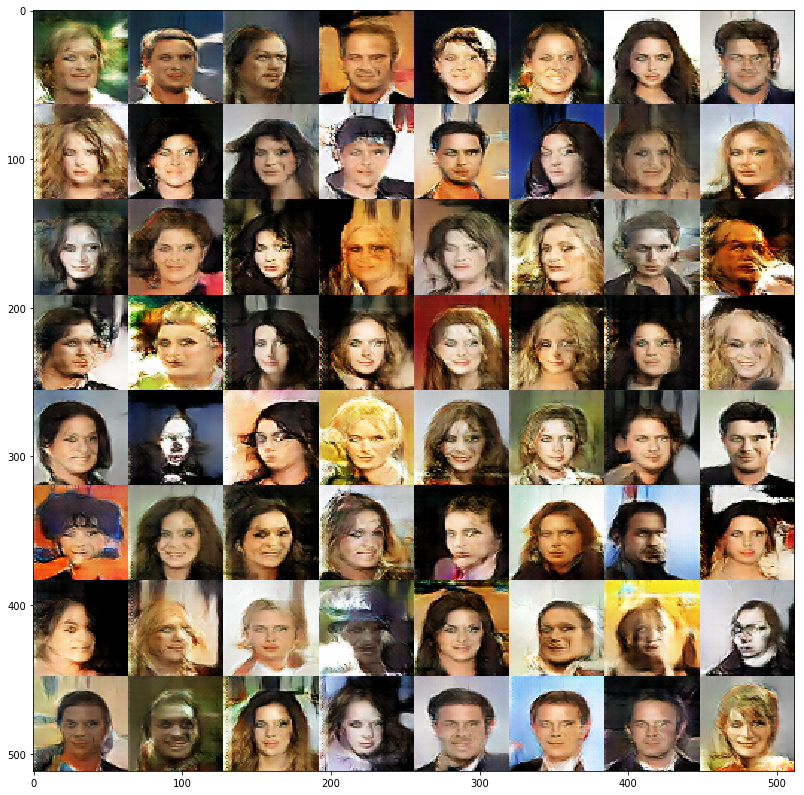

In [18]:
# Result of training.
plt.figure(figsize=(14,14))
img = imread('sample_faces/train_02_2285.png').astype(int)
imshow(img)

In [19]:
# Interpolation.
z1 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)
alpha = np.random.rand(BATCH_SIZE,100)
batchz = (alpha*z1 + (1-alpha)*z2)
with tf.Session() as sess:
    load(sess, 'checkpoint/')
    samples = sess.run(G, feed_dict={z: batchz, is_training: False})
    save_images(samples, [int(BATCH_SIZE**(0.5)), int(BATCH_SIZE**(0.5))], \
                os.path.join('sample_faces/', 'samples.png'))

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


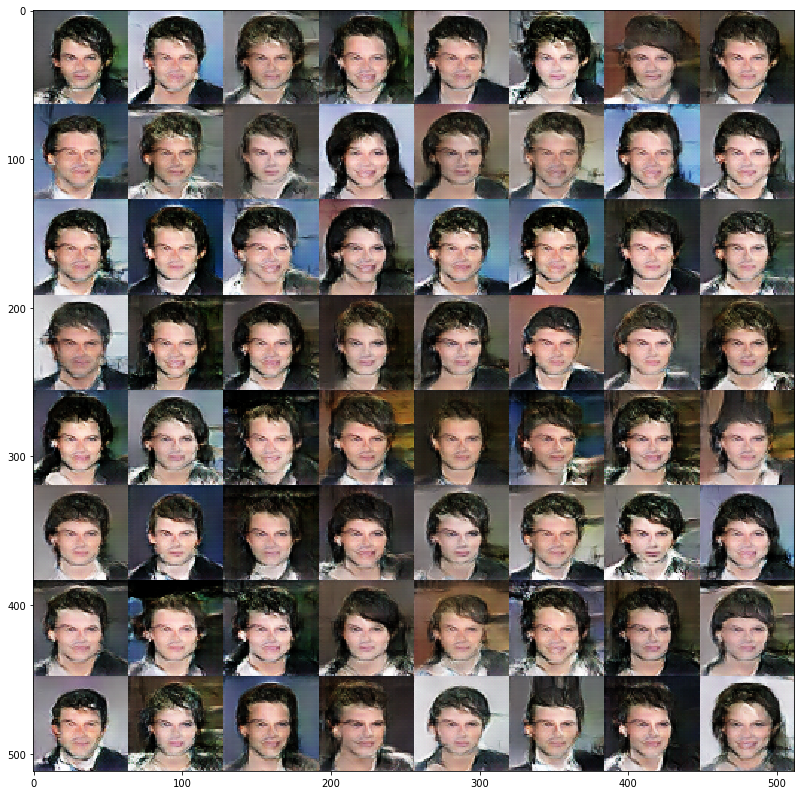

In [20]:
plt.figure(figsize=(14,14))
img = imread('sample_faces/samples.png').astype(int)
imshow(img)